In [ ]:
import yaml
from yaml.loader import SafeLoader
import numpy as np
from copy import deepcopy
from __future__ import annotations
from dataclasses import field
import sys

In [ ]:
import logging
file_handler = logging.FileHandler(filename='app.log')
stdout_handler = logging.StreamHandler(stream=sys.stdout)
# stderr_handler =logging.StreamHandler(stream=sys.stderr)
# handlers = [file_handler , stderr_handler, stdout_handler]
handlers = [file_handler , stdout_handler]

logging.basicConfig(format='%(asctime)s %(levelname)-8s %(message)s',
                    encoding='utf-8', 
                    level=logging.DEBUG,
                    datefmt='%Y-%m-%d %H:%M:%S',
                    handlers=handlers)

In [ ]:
logging.info("read_yaml conversion started!")

In [ ]:
# Open the file and load the file
with open('IEA-15-240-RWT_new.yaml') as f:
    data = yaml.load(f, Loader=SafeLoader)

In [ ]:
print(data.keys())

dict_keys(['name', 'description', 'jobname', 'assembly', 'simulationparamter', 'environment', 'components', 'airfoils', 'materials', 'control', 'bos', 'costs'])


# Constant Parameters

In [ ]:
scaling_blade = 1; 
scaling_tower = 1;
cos_msl       = np.array([0.0, 0.0, 0.0])                                                 # MSL position in global coordinate system

n_yaw         = np.array([[0, 0, 1]])                                                 # yaw rotation axis
n_tilt        = np.array([[0, 1, 0]])                                                # tilt rotation axis

flag_tower       = 1;                                                  # - tower on(1)/off(0)
flag_tower_aero  = 1;                                                  # - tower aero grid on(1)/off(0)
flag_tower_struc = 1;                                                  # - tower aero grid on(1)/off(0)

flag_blade       = 1;                                                  # - blades on(1)/off(0)
flag_blade_aero  = 1;                                                  # - blades aero grid on(1)/off(0)
flag_blade_struc = 1;                                                  # - blades structure mesh on(1)/off(0)

flag_foundation       = 1;                                             # - foundation on(1)/off(0)
flag_foundation_aero  = 1;                                             # - foundation aero grid on(1)/off(0)
flag_foundation_struc = 1;                                             # - foundation structure mesh on(1)/off(0)

flag_hub     = 1;                                                      # - hub on(1)/off(0)
flag_nacelle = 1;  

In [ ]:
mspan = data["components"]["blade"]["DeSiO"]["uvlm"]["M_aero"]
print(f"mspan : {mspan}")

mspan : 40


In [ ]:
jobname      = 'mesh_tests_blade'; 
if "jobname" in data.keys():
    strfilename = data["jobname"]
else:
    strfilename = jobname
strfilename = strfilename + \
                '_pitch' + \
                str(data["environment"]["pitch_angle"]) + \
                '_vel' + \
                str(data["environment"]["vinf"]) + \
                '_nspan' + \
                str(data["components"]["blade"]["DeSiO"]["uvlm"]["M_aero"]) + \
                '_test'

# Environmnet Conditions

In [ ]:
yaw_angle = 0.0;
pitch_angle = 0.0;
if "environment" in data.keys():
    if "yaw_angle" in data["environment"].keys():
        yaw_angle = data["environment"]["yaw_angle"]
    if "pitch_angle" in data["environment"].keys():
        pitch_angle = data["environment"]["pitch_angle"]
fsi_radius_rbf = 0;
if 'fsi_radius_rbf' in data["simulationparamter"].keys():
    fsi_radius_rbf = data["simulationparamter"]["fsi_radius_rbf"];

In [ ]:
from scipy.interpolate import interp1d
from math import pi, cos, sin

class Beam:
    def __init__(self,strName,model_beam, materials):
        
        self.strName = strName
        self.materials = materials
        # span wise discritization
        self.model_beam = model_beam
        self.M = model_beam["M_struc"]
        # initializing stiffness and mass matrix
        self.arr_stiff_matrix = np.zeros((self.M,21))
        self.arr_mass_matrix = np.zeros((self.M,6))
        self.O = np.zeros((self.M,1));
        
        # nodal natural coordinates in span-wise direction
        self.xhi_x  = np.arange(0,1 + 1/self.M,1/self.M)
        # print(f"xhi_x.shape : {self.xhi_x.shape}")
        
        # element natural coordinates in span-wise direction
        self.xhi_x_elem = (self.xhi_x[0:-1]+self.xhi_x[1:])/2
        # print(f"xhi_x_elem.shape : {self.xhi_x_elem.shape}")
        self.interpolate_ref_values()
        
        self.connectivity = np.zeros((self.M,3))
        self.arr_coordinates = [] 
    def __repr__(self) -> str:
        output_str = self.strName + "("
        output = dict()
        if "blade" in self.strName:
            output = {"M": self.M, 
                      "arr_stiff_matrix" : self.arr_stiff_matrix,
                      "arr_mass_matrix" : self.arr_mass_matrix, 
                    "arr_xre_x" : self.arr_xre_x, 
                    "arr_xre_y" : self.arr_xre_y,
                    "arr_xre_z" : self.arr_xre_z,
                    "arr_twist" : self.arr_twist,
                    "dissipation" : self.dissipation,
                    "arr_coordinates" : self.arr_coordinates,
                    "connectivity" : self.connectivity}
        elif "pipe" in self.strName:
            output = {"M": self.M, 
                        "arr_stiff_matrix" : self.arr_stiff_matrix,
                        "arr_mass_matrix" : self.arr_mass_matrix, 
                        "arr_xre_x" : self.arr_xre_x, 
                        "arr_xre_y" : self.arr_xre_y,
                        "arr_xre_z" : self.arr_xre_z,
                        "arr_outer_diameter" : self.arr_outer_diameter,
                        "arr_thickness" : self.arr_thickness,
                        "arr_EA" : self.arr_EA,
                        "arr_GA1" : self.arr_GA1,
                        "arr_GA2" : self.arr_GA2,
                        "arr_EI1" : self.arr_EI1,
                        "arr_EI2" : self.arr_EI2,
                        "arr_GI3" : self.arr_GI3,
                        "arr_ES1" : self.arr_ES1,
                        "arr_ES2" : self.arr_ES2,
                        "arr_GS2" : self.arr_GS2,
                        "arr_GS1" : self.arr_GS1,
                        "arr_EI12" : self.arr_EI12,
                        "arr_rhoA" : self.arr_rhoA,
                        "arr_rhoI1" : self.arr_rhoI1,
                        "arr_rhoI2" : self.arr_rhoI2,
                        "arr_rhoI12" : self.arr_rhoI12,
                        "arr_rhoS1" : self.arr_rhoS1,
                        "arr_rhoS2" : self.arr_rhoS2,
                        "arr_twist" : self.arr_twist,
                        "dissipation" : self.dissipation,
                        "arr_coordinates" : self.arr_coordinates,
                        "connectivity" : self.connectivity}
        output_str = output_str + \
                    ', \n'.join(f'{key}:{value}' for key, value in output.items()) \
                    + ")"
                
        return output_str
    def ifassign(self,field, subkey, xq):
        """
            This function checks if the subkey is available in the field.keys
            if it does the it does linear interpolation between grid and values
            Inputs:
                field: dict
                subkey: str
                xq: querry points
        """
        if subkey in field.keys():
            x = field[subkey]["grid"]
            y = field[subkey]["values"]
            fun = interp1d(x,y)
            return fun(xq)
    def interpolate_cross_sectional(self):
        # if-statement according to type of surface cross-section
        if "blade" in self.strName:
            # interpolating along span-wise direction
            if 'six_x_six' in self.model_beam["elastic_properties_mb"]:
                x_el_phy = self.model_beam["elastic_properties_mb"]["six_x_six"]["stiff_matrix"]["grid"]
                
                self.model_beam["elastic_properties_mb"]["six_x_six"]["stiff_matrix"]["values"] = np.asarray(self.model_beam["elastic_properties_mb"]["six_x_six"]["stiff_matrix"]["values"])
                for i in range(21):
                    
                    
                    x_el_ref = self.model_beam["elastic_properties_mb"]["six_x_six"]["stiff_matrix"]["values"][:,i]
                    
                    el_model = interp1d(x_el_phy, x_el_ref)
                    self.arr_stiff_matrix[:,i] = el_model(self.xhi_x_elem)
                x_in_phy = self.model_beam["elastic_properties_mb"]["six_x_six"]["inertia_matrix"]["grid"]
                self.model_beam["elastic_properties_mb"]["six_x_six"]["inertia_matrix"]["values"] = np.asarray(self.model_beam["elastic_properties_mb"]["six_x_six"]["inertia_matrix"]["values"])
                for i in range(6):
                    x_in_ref = self.model_beam["elastic_properties_mb"]["six_x_six"]["inertia_matrix"]["values"][:,i]
                    in_model = interp1d(x_in_phy, x_in_ref)
                    self.arr_mass_matrix[:,i] = in_model(self.xhi_x_elem)
                self.dissipation = np.asarray([self.model_beam["dissipation"]["alpha_s"], self.model_beam["dissipation"]["alpha_v"]])
            else:
                self.arr_EA  = np.zeros((self.M,1)); 
                self.arr_GA1 = np.zeros((self.M,1)); 
                self.arr_GA2 = np.zeros((self.M,1));
                self.arr_EI1 = np.zeros((self.M,1)); 
                self.arr_EI2 = np.zeros((self.M,1)); 
                self.arr_GI3 = np.zeros((self.M,1));
                self.arr_ES1 = np.zeros((self.M,1)); 
                self.arr_ES2 = np.zeros((self.M,1)); 
                self.arr_EI12 = np.zeros((self.M,1));
                self.arr_GS1 = np.zeros((self.M,1)); 
                self.arr_GS2 = np.zeros((self.M,1));

                self.arr_rhoA  = np.zeros((self.M,1)); self.arr_rhoI1 = np.zeros((self.M,1)); self.arr_rhoI2  = np.zeros((self.M,1));
                self.arr_rhoS1 = np.zeros((self.M,1)); self.arr_rhoS2 = np.zeros((self.M,1)); self.arr_rhoI12 = np.zeros((self.M,1));

                if 'EA' in self.model_beam["elastic_properties_mb"].keys():
                    x = self.model_beam["elastic_properties_mb"]["EA"]["grid"]
                    y = self.model_beam["elastic_properties_mb"]["EA"]["values"]
                    fun = interp1d(x,y)
                    self.arr_EA   = fun(self.xhi_x_elem);


                
                self.arr_GA1  = self.ifassign(self.model_beam["elastic_properties_mb"],'GA1',self.xhi_x_elem)
                self.arr_GA2  = self.ifassign(self.model_beam["elastic_properties_mb"],'GA2',self.xhi_x_elem)
                self.arr_EI1  = self.ifassign(self.model_beam["elastic_properties_mb"],'EI1',self.xhi_x_elem)
                self.arr_EI2  = self.ifassign(self.model_beam["elastic_properties_mb"],'EI2',self.xhi_x_elem)
                self.arr_GI3  = self.ifassign(self.model_beam["elastic_properties_mb"],'GI3',self.xhi_x_elem)
                self.arr_ES1  = self.ifassign(self.model_beam["elastic_properties_mb"],'ES1',self.xhi_x_elem)
                self.arr_ES2  = self.ifassign(self.model_beam["elastic_properties_mb"],'ES2',self.xhi_x_elem)
                self.arr_GS1  = self.ifassign(self.model_beam["elastic_properties_mb"],'GS1',self.xhi_x_elem)
                self.arr_GS2  = self.ifassign(self.model_beam["elastic_properties_mb"],'GS2',self.xhi_x_elem)
                self.arr_EI12  = self.ifassign(self.model_beam["elastic_properties_mb"],'EI12',self.xhi_x_elem)
                self.arr_rhoA  = self.ifassign(self.model_beam["elastic_properties_mb"],'rhoA',self.xhi_x_elem)
                self.arr_rhoI1  = self.ifassign(self.model_beam["elastic_properties_mb"],'rhoI1',self.xhi_x_elem)
                self.arr_rhoI2  = self.ifassign(self.model_beam["elastic_properties_mb"],'rhoI2',self.xhi_x_elem)
                self.arr_rhoS1  = self.ifassign(self.model_beam["elastic_properties_mb"],'rhoS1',self.xhi_x_elem)
                self.arr_rhoS2  = self.ifassign(self.model_beam["elastic_properties_mb"],'rhoS2',self.xhi_x_elem)
                self.arr_rhoI12  = self.ifassign(self.model_beam["elastic_properties_mb"],'rhoI12',self.xhi_x_elem)

                
                # GA1 GA2 EA EI1 EI2 GI3 0 0 0 GS2 -GS1 0 0 0 0 0 ES1 -EI12 -ES2 0 0
                self.arr_stiff_matrix[:,:] = [self.arr_GA1, self.arr_GA2, self.arr_EA, self.arr_EI1, self.arr_EI2, self.arr_GI3, \
                                                self.O, self.O, self.O, self.arr_GS2, -self.arr_GS1, self.O, self.O, self.O, self.O, self.O, self.arr_ES1, -self.arr_EI12,\
                                              -self.arr_ES2, self.O, self.O];

                # rhoA, rhoI2, rhoI1, rhoI12, rhoS1, rhoS2
                self.arr_mass_matrix[:,:]   = [self.arr_rhoA, self.arr_rhoI2, self.arr_rhoI1, self.arr_rhoI12, self.arr_rhoS1, self.arr_rhoS2];
                self.dissipation         = np.asarry([self.model_beam["dissipation"]["alpha_s"], self.model_beam["dissipation"]["alpha_v"]])
        
        if 'pipe' in self.strName:
            # interpolating cross-section properties along span-wise direction
            E = 0.0; G = 0.0; rho = 0.0;

            # self.materials is the list of dictionaries of cross-section properties
            if 'material' in self.model_beam.keys():
                strmaterial = self.model_beam["material"];
                for i in range(len( self.materials )):
                    if strmaterial in self.materials[i]["name"]:
                        if len(self.materials[i]["name"]) == len(strmaterial):
                            E   = self.materials[i]["E"]
                            nu  = self.materials[i]["nu"]
                            rho = self.materials[i]["rho"]
                            G   = E/(2.0*(1.0+nu))




            if 'elastic_properties_mb' in self.model_beam.keys():
                E   = self.model_beam["elastic_properties_mb"]["E"];
                G   = E/(2.0*(1+self.model_beam["elastic_properties_mb"]["nu"]));
                rho = self.model_beam["elastic_properties_mb"]["rho"];


            k1  = 1.0;
            k2  = 1.0;
            if 'shear_factor' in self.model_beam.keys():
                k1 = self.model_beam["shear_factor"]["k1"];
                k2 = self.model_beam["shear_factor"]["k2"];


            self.arr_outer_diameter = self.ifassign(self.model_beam,"outer_diameter",self.xhi_x_elem)
            
            self.arr_thickness      = self.ifassign(self.model_beam,"thickness",self.xhi_x_elem)
            self.arr_EA             = E*pi/4*(self.arr_outer_diameter**2 - (self.arr_outer_diameter-2*self.arr_thickness)**2);
            self.arr_GA1            = k1*G*pi/4*(self.arr_outer_diameter**2 - (self.arr_outer_diameter-2*self.arr_thickness)**2);
            self.arr_GA2            = k2*G*pi/4*(self.arr_outer_diameter**2 - (self.arr_outer_diameter-2*self.arr_thickness)**2);
            self.arr_EI1            = E*pi/64*(self.arr_outer_diameter**4 - (self.arr_outer_diameter-2*self.arr_thickness)**4);
            self.arr_EI2            = E*pi/64*(self.arr_outer_diameter**4 - (self.arr_outer_diameter-2*self.arr_thickness)**4);
            self.arr_GI3            = G*pi/32*(self.arr_outer_diameter**4 - (self.arr_outer_diameter-2*self.arr_thickness)**4);
            self.arr_ES1            = self.arr_EA*0;
            self.arr_ES2            = self.arr_EA*0;
            self.arr_GS2            = self.arr_EA*0;
            self.arr_GS1            = self.arr_EA*0;
            self.arr_EI12           = self.arr_EA*0;

            self.arr_rhoA           = rho*pi/4*(self.arr_outer_diameter**2 - (self.arr_outer_diameter-2*self.arr_thickness)**2);
            self.arr_rhoI1          = rho*pi/64*(self.arr_outer_diameter**4 - (self.arr_outer_diameter-2*self.arr_thickness)**4);
            self.arr_rhoI2          = rho*pi/64*(self.arr_outer_diameter**4 - (self.arr_outer_diameter-2*self.arr_thickness)**4);
            self.arr_rhoI12         = self.arr_rhoA*0;
            self.arr_rhoS1          = self.arr_rhoA*0;
            self.arr_rhoS2          = self.arr_rhoA*0;

            # print(type(self.arr_GA1), self.arr_GA1.shape)
            # print(type(self.arr_GA2), self.arr_GA2.shape)
            # print(type(self.arr_EA), self.arr_EA.shape)
            # print(type(self.arr_EI1), self.arr_EI1.shape)
            # print(type(self.arr_EI2), self.arr_EI2.shape)
            # print(type(self.arr_GI3), self.arr_GI3.shape)
            # print(type(self.arr_ES1), self.arr_ES1.shape)
            # print(type(self.arr_ES2), self.arr_ES2.shape)
            # print(type(self.arr_GS1), self.arr_GS1.shape)
            # print(type(self.arr_GS2), self.arr_GS2.shape)
            # print(type(self.arr_EI12), self.arr_EI12.shape)
            # print(type(self.O), self.O.shape)

            O = self.O[:,0]
            # GA1 GA2 EA EI1 EI2 GI3 0 0 0 GS2 -GS1 0 0 0 0 0 ES1 -EI12 -ES2 0 0
            self.arr_stiff_matrix[:,:] = np.vstack([self.arr_GA1, self.arr_GA2, self.arr_EA, self.arr_EI1, self.arr_EI2, self.arr_GI3, \
                                            O, O, O, \
                                                self.arr_GS2, -self.arr_GS1, \
                                                    O, O, O, O, O, \
                                                        self.arr_ES1, -self.arr_EI12, -self.arr_ES2, \
                                                             O, O]).T

            self.arr_mass_matrix[:,:] = np.vstack([self.arr_rhoA, self.arr_rhoI2, \
                                                    self.arr_rhoI1, self.arr_rhoI12, \
                                                        self.arr_rhoS1, self.arr_rhoS2]).T
            self.dissipation       = np.asarray([ self.model_beam["dissipation"]["alpha_s"], self.model_beam["dissipation"]["alpha_v"]])                  
        
    def interpolate_ref_values(self):
        x_phy = self.model_beam["reference_axis"]["x"]["grid"]
        y_phy = self.model_beam["reference_axis"]["y"]["grid"]
        z_phy = self.model_beam["reference_axis"]["z"]["grid"]
        x_ref = self.model_beam["reference_axis"]["x"]["values"]
        y_ref = self.model_beam["reference_axis"]["y"]["values"]
        z_ref = self.model_beam["reference_axis"]["z"]["values"]
        fx = interp1d(x_phy, x_ref)
        fy = interp1d(y_phy, y_ref)
        fz = interp1d(z_phy, z_ref)
        self.arr_xre_x = fx(self.xhi_x)
        self.arr_xre_y = fy(self.xhi_x)
        self.arr_xre_z = fz(self.xhi_x)
        
        # interpolating twist angle according to span-wise discretization
        if 'twist' in self.model_beam.keys():
            phi_phy = self.model_beam["twist"]["grid"]
            phi_ref = self.model_beam["twist"]["values"]
            phi_interp = interp1d(phi_phy, phi_ref)
            self.arr_twist = phi_interp(self.xhi_x);
        self.interpolate_cross_sectional()
        
        
def fun_extract_beam_data(strName,model_beam,materials):
    """
         input:
           strName - type of surface of (airfoil) cross-section
           model - component beam object specified in WindIO
           materials - material data specified in WindIO
           scale_opt - scaling factor for scaling in longitudinal direction (optional input)
         output:
             beam - beam object containing coordinates and connectivity for creating structural mesh
    """
  
    # span-wise discretization
    beam = Beam(strName,model_beam,materials)
    return beam
# tower_Struc  = fun_get_beam_model('pipe',data["components"]["tower"]["DeSiO"]["beam"],
#                                       data["materials"],scaling_tower);      # create structural mesh


In [ ]:
def fun_get_beam_model(strName,model,materials,scale_opt=1):
    """
         input:
           strName - type of surface of (airfoil) cross-section
           model - component beam object specified in WindIO
           materials - material data specified in WindIO
           scale_opt - scaling factor for scaling in longitudinal direction (optional input)
         output:
           beam - beam object containing coordinates and connectivity for creating structural mesh
    """
    beam  = fun_extract_beam_data(strName,model,materials)
    # print(beam)
    scale = scale_opt
    # twist angle around pitch axis
    arr_twist = np.zeros((beam.M+1,1))
    if 'twist' in model.keys():
        arr_twist = -beam.arr_twist;


    # reference axis
    arr_xre   = np.vstack([beam.arr_xre_x, \
                            beam.arr_xre_y, \
                            beam.arr_xre_z*scale]).T

    # beam position and director coordinates of the reference axis
    beam.arr_coordinates = [];
    for i in range(model["M_struc"]+1):

        # save the old directors from the previous segment
        if i == 0:
            d1_old = np.asarray([[1], [0], [0]]);
            d2_old = np.asarray([[0], [1], [0]]);
            d3_old = np.asarray([[0], [0], [1]]);
            alpha_old = 0;
        else:

            alpha_old = arr_twist[i-1];
            d1_old = d1;
            d2_old = d2;
            d3_old = d3;

        assert d1_old.ndim == 2, "d1 should have 2 dim array"
        assert d2_old.ndim == 2, "d2 should have 2 dim array"
        assert d3_old.ndim == 2, "d3 should have 2 dim array"
        # compute the new 3-director
        n3 = np.zeros((3, 1));   # the current connection vector
        if i == model["M_struc"]:
            n3[:,0] = arr_xre[i,:] - arr_xre[i-1,:];  # exeption at last node: connection interpolated backwards
        else:
            n3[:,0] = arr_xre[i+1,:] - arr_xre[i,:];  # usual case: connection interpolated forward

        d3 = n3/np.linalg.norm(n3);   # 3-director as normed connection vector

        # compute the angle between old and new 3-director and the
        # corresponding rotation axis
        theta = np.arccos(np.dot(d3_old.flatten(), d3.flatten()));   # rotation angle
        # if i == model["M_struc"]:
        #     print(f"theta = {theta}")
        # compute the rotation axis for the computation with the new
        # 3-director if the rotation angle is not very small
        if theta <= 1e-6 or np.isnan(theta):   # special case (for the last segment): the old and new director are very similar --> then just use one of the old directors as 
            rot_matrix = np.eye(3);
        else:
            temp = np.cross(d3_old.flatten(), d3.flatten())
            rot_axis = temp/np.linalg.norm(temp);   # direction vector of the rotation axis
            u_x = rot_axis[0];  # 1-component of the rotation axis
            u_y = rot_axis[1];  # 2-component of the rotation axis
            u_z = rot_axis[2];  # 3-component of the rotation axis

        # compute the rotation matrix
            rot_matrix = np.asarray([
            [cos(theta) + u_x**2*(1-cos(theta)),          u_x*u_y*(1-cos(theta)) - u_z*sin(theta),	u_x*u_z*(1-cos(theta)) + u_y*sin(theta)],
            [u_y*u_x*(1-cos(theta)) + u_z * sin(theta),    cos(theta) + u_y**2*(1-cos(theta)),          u_y*u_z*(1-cos(theta)) - u_x*sin(theta)],
            [u_z*u_x*(1-cos(theta)) - u_y*sin(theta),    u_z*u_y*(1-cos(theta)) + u_x*sin(theta),    cos(theta) + u_z**2*(1-cos(theta))]
                    ]);


        # rotate the directors to get the new COS (without twist)
        d3_check = rot_matrix @ d3_old;
        d3_diff = d3 - d3_check;
        if np.linalg.norm(d3_diff)>1e-10:
            print('ERROR: rotation does not work as inted');
            print(d3_old);
            print(d3);
            print(d3_check);
            return

        d2_noTw = rot_matrix @ d2_old
        d1_noTw = rot_matrix @ d1_old

        # include the twist
        alpha_tw = arr_twist[i] - alpha_old;   # current twist angle

        # rotation axis for the twist rotation: the current 3-director
        rot_axis = d3;
        u_x = float(rot_axis[0])  # 1-component of the rotation axis
        u_y = float(rot_axis[1])  # 2-component of the rotation axis
        u_z = float(rot_axis[2])  # 3-component of the rotation axis

        # compute the rotation matrix for the twist rotation
        rot_matrix_Tw = np.asarray([
        [cos(alpha_tw) + u_x**2*(1-cos(alpha_tw)),          u_x*u_y*(1-cos(alpha_tw)) - u_z*sin(alpha_tw),	u_x*u_z*(1-cos(alpha_tw)) + u_y*sin(alpha_tw)],
        [u_y*u_x*(1-cos(alpha_tw)) + u_z*sin(alpha_tw),	cos(alpha_tw) + u_y**2*(1-cos(alpha_tw)),          u_y*u_z*(1-cos(alpha_tw)) - u_x*sin(alpha_tw)],
        [u_z*u_x*(1-cos(alpha_tw)) - u_y*sin(alpha_tw),    u_z*u_y*(1-cos(alpha_tw)) + u_x*sin(alpha_tw),    cos(alpha_tw) + u_z**2*(1-cos(alpha_tw))]
        ]);

        # compute the new directors
        d1 = rot_matrix_Tw @ d1_noTw
        d2 = rot_matrix_Tw @ d2_noTw

        # transpose the vectors for output
#         d1 = d1';
#         d2 = d2';
#         d3 = d3';

        # write the computed current director and reference point to the output-array
        temp = np.expand_dims(arr_xre[i,:],0)
        temp = np.hstack([temp,d1.T,d2.T,d3.T])
        # print(f"temp.shape = {temp.shape}")
        beam.arr_coordinates.append(temp[0,:])
        



    beam.arr_coordinates = np.asarray(beam.arr_coordinates)
    # beam connectivities
    for i in range(model["M_struc"]):
        beam.connectivity[i,:] = [i,i+1,i];
    return beam


In [ ]:
def if_assign(field, subkey, xq, sep_values=None):
    """
        This function checks if the subkey is available in the field.keys
        if it does the it does linear interpolation between grid and values
        Inputs:
            field: dict
            subkey: str
            xq: querry points
            sep_values: If this is defined it will treated as y for the interpolation
    """
    if sep_values is None:
        if subkey in field.keys():
            x = field[subkey]["grid"]
            y = field[subkey]["values"]
            fun = interp1d(x,y)
            return fun(xq)
    else:
        if subkey in field.keys():
            x = field[subkey]["grid"]
            y = sep_values
            fun = interp1d(x,y)
            return fun(xq)
def interp1D(array, xq):
    x = array[:,0]
    y = array[:,1]
    fun = interp1d(x,y)
    return fun(xq)
class UVLM:
    def __init__(self, strName,model_uvlm,airfoils):
        # span-wise and chord-wise discretization
        self.M = model_uvlm["M_aero"]
        self.N = model_uvlm["N_aero"]
        
        # natural coordinates of span-and chord-wise discretization
        self.xhi_x  = np.arange(0,1 + 1/self.M,1/self.M) # span-wise
        self.xhi_y_c  = np.arange(0,1 + 1/self.N,1/self.N) # chord-wise

        self.connectivity_c = []
        self.connectivity_w = []
        
        
    

        nbr             = 0;                    # number of blade root cross-section
        arr_inz_airfoil = [];                   # index array for locating airfoils in span-wise direction
        
        # interpolating coordinates of reference axis according to span-wise discretization
        self.arr_xre_x = if_assign(model_uvlm["reference_axis"], "x", self.xhi_x)
        self.arr_xre_y = if_assign(model_uvlm["reference_axis"], "y", self.xhi_x)
        self.arr_xre_z = if_assign(model_uvlm["reference_axis"], "z", self.xhi_x)
        arr_val_c = []
        arr_val_w = []
        
        self.arr_node_fsi_radius_w = []
        self.arr_node_fsi_radius = []
        # if-statement according to type of surface cross-section
        if "blade" in strName:
            self.airfoil = model_uvlm["airfoil_position"]
            nbr              = model_uvlm["blade_root_position"]

            # interpolating chord length in span-wise direction
            self.arr_c = if_assign(model_uvlm, "chord", self.xhi_x)

            # interpolating twist angle according to span-wise discretization
            self.arr_twist = np.zeros((self.M,1))
            
            self.arr_twist = if_assign(model_uvlm, "twist", self.xhi_x)
            
            # interpolating airfoil in span-wise direction. This is important
            # to identify the blade root and blade's lifting surfaces
            airfoil_grid    = self.airfoil["grid"]
            # TODO:
#             airfoil_values  = [1:length(uvlm_obj.airfoil.grid)]
#             print(self.airfoil)
#             print('*'*80)
#             print(len(airfoils))
#             print(airfoils[0].keys())
            airfoil_values  = range(len(self.airfoil["grid"]))
            fun = interp1d(airfoil_grid,airfoil_values)
            arr_inz_airfoil = np.fix(fun(self.xhi_x))

            arr_pitch_ax = np.ones((self.M+1,1))*1.0;
            self.arr_pitch_ax = if_assign(model_uvlm, "pitch_axis",self.xhi_x)
            
            # natural coordinates of chord-wise discretization for whole
            # surface of cross-section
            xhi_y_w = self.xhi_y_c;
        elif "pipe" in strName:
            logging.debug("UVLM class:\nInside pipe:")
            # interpolating chord length in span-wise direction
            temp = np.asarray(model_uvlm["outer_diameter"]["values"]) \
                - np.asarray(model_uvlm["thickness"]["values"])
            logging.debug('model_uvlm["outer_diameter"]["values"]: ' + str(model_uvlm["outer_diameter"]["values"]) )
            logging.debug('model_uvlm["thickness"]["values"]: ' + str(model_uvlm["thickness"]["values"]) )
            self.arr_c          = if_assign(model_uvlm,
                                            "outer_diameter",
                                            self.xhi_x, # these are query points
                                            temp # this is y for interpolation
                                           );
            self.arr_twist      = np.zeros((self.M+1,1)) # zero twist
            self.arr_pitch_ax   = np.ones((self.M+1,1))*0.5; # location of pitch axis
            self.airfoil = {}
            self.airfoil["labels"] = ['circular','circular']  # artificial "airfoil" sections for pipe
            self.airfoil["grid"]   = [0.0, 1.0];               # artificial "airfoil" sections grid for pipe

            # mesh discretization around circular cross-section
            temp = np.linspace(0,np.pi, self.N+1)
            xhi_y_w = 0.5*(1-np.cos(temp))
        # loop over airfoils in the model to calculate coordinates of
        # cross-section surfaces
        for i in range(len(self.airfoil["labels"])):
            airfoil_name = self.airfoil["labels"][i]

            # searching current airfoil from airfoil-list
            for j in range(len(airfoils)):
                if len(airfoils) == 1:
                    if airfoil_name in airfoils[j]["name"]:
                        airfoilj = airfoils;
                        break

                else:
                    if airfoil_name in airfoils[j]["name"]  :
                        airfoilj = airfoils[j]
                        break




            # extracting coordinates for upper and lower airfoil 
            airfoil_coord = np.vstack([airfoilj["coordinates"]["x"],airfoilj["coordinates"]["y"]]).T
            logging.debug(f"airfoil_coord.shape: {airfoil_coord.shape}")
            inz0 = np.nonzero(airfoil_coord[:,0]==0) 
            inz0 = inz0[0][0] + 1
            logging.debug(f"inz0: {inz0}")
            airfoil_coord_u = airfoil_coord[:inz0,:]; 
            inzsort = np.argsort(airfoil_coord_u[:,0])
            airfoil_coord_u = airfoil_coord_u[inzsort,:]
            airfoil_coord_l = airfoil_coord[inz0-1:,:]; 
            inzsort = np.argsort(airfoil_coord_l[:,0]) 
            airfoil_coord_l = airfoil_coord_l[inzsort,:]

            # interpolating values in airfoil thickness direction according to
            # discretization in chord-wise direction to calculate camber
            # surface coordinates
#             print("airfoil_coord_u: ",airfoil_coord_u)
            xhi_airf_u = interp1D(airfoil_coord_u,self.xhi_y_c);
            xhi_airf_l = interp1D(airfoil_coord_l,self.xhi_y_c);
            # coordinates of camber surface
#             print(xhi_airf_u.shape, xhi_airf_l.shape)
            xhi_airf_c = (xhi_airf_u + xhi_airf_l)/2;

            # interpolating values in airfoil thickness direction according to
            # discretization in chord-wise direction to calculate whole
            # cross-section surface coordinates
            xhi_airf_u = interp1D(airfoil_coord_u,xhi_y_w);
            xhi_airf_l = interp1D(airfoil_coord_l,xhi_y_w);
            # coordinates of whole cross-section surface
            xhi_airf_w = np.append(np.append(xhi_airf_u[:-1],(xhi_airf_u[-1] + xhi_airf_l[-1])/2),xhi_airf_l[-2::-1])
#             print("xhi_airf_w.shape: ",xhi_airf_w.shape)
            
            # if-statement to detect, if blade root s. In case blade root
            # , switching from whole surface to camber surface
            if i == nbr+1:
                if nbr != 0:
                    xhi_airf_w = np.append(xhi_airf_c[:-1],xhi_airf_c[::-1])
#                     print("inside: xhi_airf_w.shape: ",xhi_airf_w.shape)



#             print("xhi_airf_c.shape :", xhi_airf_c.shape)
            arr_val_c.append( xhi_airf_c)      # camber surface coordinates 
            arr_val_w.append( xhi_airf_w) # whole surface coordinates
        arr_val_c = np.asarray(arr_val_c).T
        arr_val_w = np.asarray(arr_val_w).T
        

        # interpolating camber surface coordinates in span-wise direction 
        arr_xhi_airf_c = np.zeros((self.xhi_x.size, arr_val_c.shape[0]))
        for i in range(arr_val_c.shape[0]):
            x = np.asarray(self.airfoil["grid"])
            y = arr_val_c[i,:]
            # print("line 165: (x.shape, y.shape): ",x.shape, y.shape)
            fun = interp1d(x,y)
            arr_val = fun(self.xhi_x)
            arr_xhi_airf_c[:,i] = arr_val


        # interpolating whole surface coordinates in span-wise direction
        arr_xhi_airf_w =  np.zeros((self.xhi_x.size, arr_val_w.shape[0]))
        for i in range(arr_val_w.shape[0]):
            x = self.airfoil["grid"]
            y = arr_val_w[i,:]
            fun = interp1d(x,y)
            arr_val = fun(self.xhi_x)
            
            arr_xhi_airf_w[:,i] = arr_val


        if nbr!=0:
            inz  = np.nonzero(arr_inz_airfoil<=nbr)
            inz = inz[0]
            temp_coo = arr_xhi_airf_c[inz[-1]+1,:]
            arr_xhi_airf_w[inz[-1]+1,:] = np.append(temp_coo,temp_coo[-2::-1])
        self.arr_xhi_airf_c  = arr_xhi_airf_c;
        self.arr_xhi_airf_w  = arr_xhi_airf_w;
        self.xhi_y_w         = xhi_y_w;
        self.arr_xhi_x       = self.xhi_x
        self.nbr             = nbr;
        self.arr_inz_airfoil = arr_inz_airfoil;

        # elements in x (span) and y (chord) direction
        mx = len(self.arr_xhi_x) - 1
        my = self.N
        max_dim = self.arr_c.shape[0]
        dim_w = max_dim*(2*my+1)
        dim_c = max_dim*(my+1)
        self.X_W = np.zeros((dim_w,3))
        self.X_C = np.zeros((dim_c,3))
        self.X_0 = np.zeros((dim_c,3))
        self.X_0_W = np.zeros((dim_w,3))
    def __repr__(self) -> str:
        output = {"M": self.M,
                  "N": self.N,
                  "arr_xre_x": self.arr_xre_x,
                  "arr_xre_y": self.arr_xre_y,
                  "arr_xre_z": self.arr_xre_z,
                  "airfoil": self.airfoil,
                  "arr_c": self.arr_c,
                  "arr_twist": self.arr_twist,
                  "arr_pitch_ax": self.arr_pitch_ax,
                  "arr_xhi_airf_c": self.arr_xhi_airf_c,
                  "arr_xhi_airf_w": self.arr_xhi_airf_w,
                  "xhi_y_w": self.xhi_y_w,
                  "arr_xhi_x": self.arr_xhi_x,
                  "nbr": self.nbr,
                  "arr_inz_airfoil": self.arr_inz_airfoil,
                  "X_W": self.X_W,
                  "X_C": self.X_C,
                  "X_0": self.X_0,
                  "X_0_W": self.X_0_W,
                  "arr_node_fsi_radius_w": self.arr_node_fsi_radius_w,
                  "arr_node_fsi_radius": self.arr_node_fsi_radius,
                  "connectivity_c": self.connectivity_c,
                  "connectivity_w": self.connectivity_w,}

        return ', \n'.join('{}: {}'.format(k, v) for k, v in output.items())
        

            
            
    
    
        
def fun_extract_uvlm_data(strName,model_uvlm,airfoils):
    """   
     input:
       strName - type of surface of (airfoil) cross-section
       model - component uvlm object specified in WindIO
       airfoils - airfoil data specified in WindIO
     output:
         uvlm_ob - uvlm object containing coordinates and connectivity for creating aerodynamic grid
     =================================================================================================================
    """
    uvlm_ob = UVLM(strName,model_uvlm,airfoils)
    # for debugging
#     for var in vars(uvlm_ob):
#         print(f"{var} : ",getattr(uvlm_ob, var))
#         print('*'*80)
#         print('*'*80)
#         print('*'*80)
    return uvlm_ob


In [ ]:
def fun_get_uvlm_geometry(strName,model,airfoils,scale_opt=1):
    """
         Input:
           airfoils - airfoil data specified in WindIO
           scale_opt - scaling factor for scaling in longitudinal direction (optional input)
         output:
             uvlm_ob - uvlm object containing coordinates and connectivity for creating aerodynamic grid
         =================================================================================================================

    """
    # extracting uvlm data from WindIO
    uvlm_ob = fun_extract_uvlm_data(strName,model,airfoils)
    
    # elements in x (span) and y (chord) direction
    mx =  len(uvlm_ob.arr_xhi_x)-1; 
    my =  uvlm_ob.N;
    
    # natural coordinates in chord-wise direction of cross-section
    xhi_y_c   = uvlm_ob.xhi_y_c;                                            # camber surface
    xhi_y_w   = np.append(uvlm_ob.xhi_y_w, uvlm_ob.xhi_y_w[-2::-1])       # whole surface of cross-section
    
    # some extracted geometry arrays interpolated to spatial discretization
    arr_chord      = uvlm_ob.arr_c;                                         # chord length c
    arr_pitch_ax   = uvlm_ob.arr_pitch_ax;                                  # position of pitch axis in c
    arr_xhi_airf_c = uvlm_ob.arr_xhi_airf_c;                                # camber surface of (ariofoil) cross-section in c
    arr_xhi_airf_w = uvlm_ob.arr_xhi_airf_w;                                # whole surface of (ariofoil) cross-section in c
    arr_twist      = -uvlm_ob.arr_twist;                                    # twist angle around pitch axis
    arr_xre        = np.vstack([uvlm_ob.arr_xre_x,uvlm_ob.arr_xre_y, uvlm_ob.arr_xre_z*scale_opt]).T       # reference axis
    arr_coordinates = np.zeros((mx+1,12))
    # position and director coordinates of the reference axis
    for i in range(mx+1):
        # save the old directors from the previous segment
        if i == 0:
            d1_old = np.asarray([[1], [0], [0]])
            d2_old = np.asarray([[0], [1], [0]])
            d3_old = np.asarray([[0], [0], [1]])
            alpha_old = 0;
        else:
            d1_old = d1   # transposed because they were transposed for the output
            d2_old = d2
            d3_old = d3
            alpha_old = arr_twist[i-1]


        # compute the new 3-director
        n3 = np.zeros((3, 1))   # the current connection vector
        if i == mx:
            n3[:,0] = arr_xre[i,:] - arr_xre[i-1,:];  # exeption at last node: connection interpolated backwards
        else:
            n3[:,0] = arr_xre[i+1,:] - arr_xre[i,:];  # usual case: connection interpolated forward

        d3 = n3/np.linalg.norm(n3);   # 3-director as normed connection vector

        # compute the angle between old and new 3-director and the
        # corresponding rotation axis
        theta = np.arccos(np.dot(d3_old[:,0], d3[:,0]));   # rotation angle
        #         if i == model.M_struc+1
        #             print('rotation angle:');
        #             print(theta);
        #         
        
        if theta <= 1e-6 or np.isnan(theta):   # special case (for the last segment): the old and new director are very similar --> then just use one of the old directors as 
            rot_matrix = np.eye(3)
        else:
            temp = np.cross(d3_old[:,0], d3[:,0])
            rot_axis = temp/np.linalg.norm(temp);   # direction vector of the rotation axis
            u_x = float(rot_axis[0])  # 1-component of the rotation axis
            u_y = float(rot_axis[1])  # 2-component of the rotation axis
            u_z = float(rot_axis[2])  # 3-component of the rotation axis
            
        #             print(rot_axis);
        #         if i == model.M_struc+1
        #             print('rotation axis:');
        #             print(rot_axis);
        #         
        # compute the rotation matrix
            rot_matrix = [
            [cos(theta) + u_x**2*(1-cos(theta)),          u_x*u_y*(1-cos(theta)) - u_z*sin(theta),	u_x*u_z*(1-cos(theta)) + u_y*sin(theta)],
            [u_y*u_x*(1-cos(theta)) + u_z*sin(theta),	cos(theta) + u_y**2*(1-cos(theta)),          u_y*u_z*(1-cos(theta)) - u_x*sin(theta)],
            [u_z*u_x*(1-cos(theta)) - u_y*sin(theta),    u_z*u_y*(1-cos(theta)) + u_x*sin(theta),    cos(theta) + u_z**2*(1-cos(theta))]]
            rot_matrix = np.asarray(rot_matrix)

        #         print(rot_matrix);

        #         if i == model.M_struc+1
        #             print('rotation matrix:');
        #             print(rot_matrix);
        #         

        # rotate the directors to get the new COS (without twist)
        d3_check = np.matmul(rot_matrix, d3_old);
        d3_diff = d3 - d3_check;
        if np.linalg.norm(d3_diff)>1e-10:
            print('ERROR: rotation does not work as inteded');
            print(d3_old);
            print(d3);
            print(d3_check);
            return

        d2_noTw = rot_matrix @ d2_old
        d1_noTw = rot_matrix @ d1_old

        # include the twist
        alpha_tw = arr_twist[i] - alpha_old;   # current twist angle

        # rotation axis for the twist rotation: the current 3-director
        rot_axis = d3
        u_x = float(rot_axis[0])  # 1-component of the rotation axis
        u_y = float(rot_axis[1])  # 2-component of the rotation axis
        u_z = float(rot_axis[2])  # 3-component of the rotation axis

        # compute the rotation matrix for the twist rotation
        rot_matrix_Tw = [
        [cos(alpha_tw) + u_x**2*(1-cos(alpha_tw)),          u_x*u_y*(1-cos(alpha_tw)) - u_z*sin(alpha_tw),	u_x*u_z*(1-cos(alpha_tw)) + u_y*sin(alpha_tw)],
        [u_y*u_x*(1-cos(alpha_tw)) + u_z*sin(alpha_tw),	cos(alpha_tw) + u_y**2*(1-cos(alpha_tw)),          u_y*u_z*(1-cos(alpha_tw)) - u_x*sin(alpha_tw)],
        [u_z*u_x*(1-cos(alpha_tw)) - u_y*sin(alpha_tw),    u_z*u_y*(1-cos(alpha_tw)) + u_x*sin(alpha_tw),    cos(alpha_tw) + u_z**2*(1-cos(alpha_tw))]]
        rot_matrix_Tw = np.asarray(rot_matrix_Tw)

        # print(f'i={i}, d1_noTw = {d1_noTw}')
        # print(f'i={i}, d1_noTw = {d2_noTw}')
        # compute the new directors
        d1 = rot_matrix_Tw @ d1_noTw
        d2 = rot_matrix_Tw @ d2_noTw

        # transpose the vectors for output
        

        # write the computed current director and reference point to the output-array
        arr_coordinates[i,:] = np.hstack([arr_xre[i,:],d1[:,0],d2[:,0],d3[:,0]])
    
    
    # calculating aerodynamic grid for DeSiO-Aero on the reference axis
    d10 = np.asarray([[1],[0],[0]] )
    d20 = np.asarray([[0],[1],[0]])
    d30 = np.asarray([[0],[0],[1]])
    for i_l in range(arr_coordinates.shape[0]):
        
        # reference position and director of/at center line
        xcenter = arr_coordinates[i_l:i_l+1,:3].T 
        d1 = arr_coordinates[i_l:i_l+1,3:6].T 
        d2 = arr_coordinates[i_l:i_l+1,6:9].T 
        d3 = arr_coordinates[i_l:i_l+1,9:12].T

        # rotation matrix for cross section orientation
        R_t = d3@d30.T + d2@d20.T + d1@d10.T
        
        # chord length and location of pitch axis
        c        = arr_chord[i_l] 
        xhi_p_ax = arr_pitch_ax[i_l]
        xhi_pn   = np.asarray([[0],[xhi_p_ax],[0]])

        # print(f'xcenter={xcenter, xcenter.shape}, xhi_p_ax={xhi_p_ax}, xhi_pn= {xhi_pn, xhi_pn.shape}, c={c}')
        # print(f'R_t={R_t}')
        # print(f'd1={d1,d1.shape}')
        # print(f'd2={d2, d2.shape}')
        # print(f'd3={d3, d3.shape}')
        
        # coordinates of whole cross-section
        dim_v = len(xhi_y_w)
        xcO = np.zeros((3,dim_v)); 
        xhi_pnO = np.zeros((3,dim_v))
        O              = np.ones((3,dim_v)) 
        xcO[:3,:]      = np.asarray([xcenter[0]*O[0,:],      xcenter[1]*O[1,:],  xcenter[2]*O[2,:]])
        xhi_pnO[:3,:]  = np.asarray([xhi_pn[0]*O[0,:],       xhi_pn[1]*O[1,:],   xhi_pn[2]*O[2,:]])
        xhi_airf_w     = np.asarray([arr_xhi_airf_w[i_l,:],  xhi_y_w,            0*O[2,:]])
        x_airf_w       = np.asarray([xhi_airf_w[0,:]*c,      xhi_airf_w[1,:]*c,  0*O[2,:]])
        
        # print(f'xcO={xcO, xcO.shape}')
        # print(f'xhi_pnO={xhi_pnO, xhi_pnO.shape}')
        # print(f'x_airf_w={x_airf_w, x_airf_w.shape}')
        # print(f'xhi_airf_w={xhi_airf_w, xhi_airf_w.shape}')


        # rotation of cross-section around pitch axis and recalcuating profile 
        # to middle axis (middle axis is on location of pitch axis)
        xp_w =  (R_t @ (x_airf_w - xhi_pnO*c)) + xcO 
        
        # print(f'xp_w={xp_w, xp_w.shape}')

        # coordinates of camber line
        dim_v = len(xhi_y_c)
        xcO = np.zeros((3,dim_v)); 
        xhi_pnO = np.zeros((3,dim_v))
        O              = np.ones((3,dim_v)) 
        xcO[:3,:]      = np.asarray([xcenter[0]*O[0,:],          xcenter[1]*O[1,:],         xcenter[2]*O[2,:]])
        xhi_pnO[:3,:]  = np.asarray([xhi_pn[0]*O[0,:],           xhi_pn[1]*O[1,:],          xhi_pn[2]*O[2,:]])
        xhi_airf_c     = np.asarray([arr_xhi_airf_c[i_l,:],      xhi_y_c,                   0*O[2,:]])
        x_airf_c       = np.asarray([xhi_airf_c[0,:]*c,          xhi_airf_c[1,:]*c,         0*O[2,:]])
        # rotation of cross-section around pitch axis and recalcuating profile 
        # to middle axis (middle axis is on location of pitch axis)
        xp_c =  (R_t @ (x_airf_c - xhi_pnO*c) )+ xcO 
        xp_0 = xcO
                
        # global node indizes for assembling and meshing
        inz_global_w = np.arange((i_l)*(2*my+1),  (i_l+1)*(2*my+1))
        inz_global_c = np.arange((i_l)*(my+1)  ,  (i_l+1)*(my+1))

        # writing into global coordinates
        # print(f'i = {i_l}, xp_w = {xp_w}')
        uvlm_ob.X_W[inz_global_w,:3] = xp_w.T
        uvlm_ob.X_C[inz_global_c,:3] = xp_c.T
        # this is only for assigning chord-length each node for fsi radius
        uvlm_ob.X_0[inz_global_c,:3]   = xp_0.T
        # logging.debug(f'uvlm_ob.X_0.shape = {uvlm_ob.X_0.shape}')
        temp = np.ones((2*my+1,1))
        # logging.debug(f'xp_0.shape = {xp_0.shape}')
        uvlm_ob.X_0_W[inz_global_w,:3] = np.hstack([xp_0[0,0] * temp,
                                            xp_0[1,0] * temp,
                                            xp_0[2,0] * temp])
        # logging.debug(f'uvlm_ob.X_0_W.shape = {uvlm_ob.X_0_W.shape}')
        
    
    logging.debug(f'uvlm_ob.X_0.shape = {uvlm_ob.X_0.shape}')
    logging.debug(f'uvlm_ob.X_0_W.shape = {uvlm_ob.X_0_W.shape}')
    logging.debug(f'xp_0.shape = {xp_0.shape}')
    # creating camber surface connectivities
    #       2 ___________ 1
    #        |           |
    #        |    BE     |   
    #        |___________|
    #        3           4
    surfaces = np.arange(0,mx*(my), dtype=int) 
    # print('surfaces.shape = ',surfaces.shape)
    connectivity_c = np.zeros((surfaces.size,4), dtype = int)    
    for j  in range(mx):
        n2 = surfaces[ j*my : j*my+ my ] + my + j+1
        n1 = n2+1
        n3 = n2-(my+1)
        n4 = n2-my
        temp = np.vstack((n1,n2,n3,n4)).T
        connectivity_c[j*my:j*my+my,:] = temp
    # creating surface connectivities of whole cross-section
    surfaces = np.arange(0,mx*(2*my), dtype=int)
    # print('surfaces.shape = ',surfaces.shape)
    connectivity_w = np.zeros((surfaces.size,4), dtype = int)

    for j  in range(mx):
        n2 = surfaces[ j * 2 * my : j * 2 * my + 2 * my ] + 2 * my + j + 1
        n1 = n2+1
        n3 = n2-(2*my+1)
        n4 = n2-2*my
        temp = np.vstack((n1,n2,n3,n4)).T
        connectivity_w[j*2*my:j*2*my+2*my,:] = temp
    # print('connectivity_w.shape=',connectivity_w.shape)
    uvlm_ob.connectivity_c = connectivity_c;
    uvlm_ob.connectivity_w = connectivity_w;
    uvlm_ob.N = my;
    uvlm_ob.M = mx;
    uvlm_ob.arr_node_fsi_radius_w = []
    for i in range((mx+1)*(2*my+1)):
        inz = np.nonzero(abs(uvlm_ob.X_0_W[i,2]) >= uvlm_ob.arr_xre_z)[0]
    
        uvlm_ob.arr_node_fsi_radius_w.append(uvlm_ob.arr_c[inz[-1]])
    uvlm_ob.arr_node_fsi_radius_w = np.asarray(uvlm_ob.arr_node_fsi_radius_w)
    
    logging.debug(f'uvlm_ob.arr_node_fsi_radius_w.shape = {uvlm_ob.arr_node_fsi_radius_w.shape}')
    logging.debug(f'uvlm_ob.arr_node_fsi_radius_w = {uvlm_ob.arr_node_fsi_radius_w}')
    uvlm_ob.arr_node_fsi_radius = [];
    for i in range((mx+1)*(my+1)):
        inz = np.nonzero(abs(uvlm_ob.X_0[i,2]) >= uvlm_ob.arr_xre_z)[0]
        uvlm_ob.arr_node_fsi_radius.append(uvlm_ob.arr_c[inz[-1]])
    uvlm_ob.arr_node_fsi_radius = np.asarray(uvlm_ob.arr_node_fsi_radius)
    logging.debug(f'uvlm_ob.arr_node_fsi_radius.shape = {uvlm_ob.arr_node_fsi_radius.shape}')
    logging.debug(f'uvlm_ob.arr_node_fsi_radius = {uvlm_ob.arr_node_fsi_radius}')

    return uvlm_ob
blade_Aero  = fun_get_uvlm_geometry('blade',
                                        data["components"]["blade"]["DeSiO"]["uvlm"],
                                        data["airfoils"],scaling_blade)
print(vars(blade_Aero))

{'M': 40, 'N': 5, 'xhi_x': array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   ]), 'xhi_y_c': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), 'connectivity_c': array([[  7,   6,   0,   1],
       [  8,   7,   1,   2],
       [  9,   8,   2,   3],
       [ 10,   9,   3,   4],
       [ 11,  10,   4,   5],
       [ 13,  12,   6,   7],
       [ 14,  13,   7,   8],
       [ 15,  14,   8,   9],
       [ 16,  15,   9,  10],
       [ 17,  16,  10,  11],
       [ 19,  18,  12,  13],
       [ 20,  19,  13,  14],
       [ 21,  20,  14,  15],
       [ 22,  21,  15,  16],
       [ 23,  22,  16,  17],
       [ 25,  24,  18,  19],
       [ 26,  25,  19,  20],
       [ 27,  26,  20,  21],
       [ 28,  27,  21,  22],
       [ 29,  28,  22,  23],
 

# Blades

In [ ]:
n_blades = 0;
if 'number_of_blades' in data["assembly"].keys():
    n_blades = data["assembly"]["number_of_blades"];
if "blade" in data["components"].keys() and flag_blade == 1:
#     blade_Aero  = fun_get_uvlm_geometry('blade',data["components"]["blade"]["DeSiO"]["uvlm"],data["airfoils"],scaling_blade);
    blade_Struc = fun_get_beam_model('blade',data["components"]["blade"]["DeSiO"]["beam"],data["materials"],scaling_blade)
    blade_Aero  = fun_get_uvlm_geometry('blade',
                                        data["components"]["blade"]["DeSiO"]["uvlm"],
                                        data["airfoils"],scaling_blade)
    wake_diffusion = 0.0
    if "wake_diffusion" in data["simulationparamter"].keys():
        wake_diffusion = data["simulationparamter"]["wake_diffusion"]
    

In [ ]:
blade_Struc

blade(M:40, 
arr_stiff_matrix:[[ 6.2970000e+09  6.3047500e+09  4.3205000e+10  1.4052500e+11
   1.4157500e+11  8.2245000e+10  0.0000000e+00  0.0000000e+00
   0.0000000e+00  1.3856250e+07 -1.4593250e+08  0.0000000e+00
   0.0000000e+00  0.0000000e+00 -1.6200500e+06  0.0000000e+00
   9.5495000e+08 -3.2615000e+08 -7.4155000e+06  0.0000000e+00
   0.0000000e+00]
 [ 4.9507500e+09  5.5412500e+09  3.6697500e+10  1.1497500e+11
   1.0817500e+11  6.3640000e+10  0.0000000e+00  0.0000000e+00
   0.0000000e+00  2.6272500e+07 -4.0160000e+08  0.0000000e+00
   0.0000000e+00  0.0000000e+00  5.4707500e+06  0.0000000e+00
   3.1675000e+09 -1.9360000e+09 -1.8627500e+08  0.0000000e+00
   0.0000000e+00]
 [ 3.6305000e+09  4.8740000e+09  3.1480000e+10  9.2580000e+10
   8.0335000e+10  4.6280000e+10  0.0000000e+00  0.0000000e+00
   0.0000000e+00  4.4580000e+07 -3.7940000e+08  0.0000000e+00
   0.0000000e+00  0.0000000e+00  1.9900000e+05  0.0000000e+00
   4.5730000e+09 -3.8815000e+09 -2.8275000e+08  0.0000000e+00
   0

In [ ]:
# output is compared with Matlab code
blade_Struc.arr_coordinates[:,3:6]

array([[ 9.63156335e-01, -2.68828254e-01, -7.82592966e-03],
       [ 9.63350406e-01, -2.68044482e-01, -1.03995898e-02],
       [ 9.64923131e-01, -2.62236491e-01, -1.24648867e-02],
       [ 9.68130158e-01, -2.50088303e-01, -1.34103459e-02],
       [ 9.72349544e-01, -2.33161478e-01, -1.31183069e-02],
       [ 9.77003311e-01, -2.12921051e-01, -1.13646551e-02],
       [ 9.81467242e-01, -1.91431094e-01, -8.72866732e-03],
       [ 9.85352032e-01, -1.70466867e-01, -4.73506883e-03],
       [ 9.88435158e-01, -1.51640669e-01, -1.02265637e-03],
       [ 9.90707179e-01, -1.36011396e-01,  4.31916028e-04],
       [ 9.92478744e-01, -1.22413680e-01,  9.12988855e-04],
       [ 9.94039761e-01, -1.09010063e-01,  1.32645598e-03],
       [ 9.95357068e-01, -9.62359664e-02,  1.71642046e-03],
       [ 9.96435716e-01, -8.43311697e-02,  2.02931427e-03],
       [ 9.97269507e-01, -7.37455466e-02,  3.88895929e-03],
       [ 9.97886678e-01, -6.44687411e-02,  8.12150823e-03],
       [ 9.98316486e-01, -5.62446952e-02

# Tower

In [ ]:
tower_top = 0;
tower_bot = 0;
if 'tower' in data["components"].keys() and flag_tower == 1:
	tower_Aero   = fun_get_uvlm_geometry('pipe',data["components"]["tower"]["DeSiO"]["uvlm"],
                                         data["airfoils"],
                                         scaling_tower);    # create 2d mesh for aero grid
	tower_Struc  = fun_get_beam_model('pipe',data["components"]["tower"]["DeSiO"]["beam"],
                                      data["materials"],scaling_tower);      # create structural mesh
	tower_top    = np.max(data["components"]["tower"]["DeSiO"]["beam"]["reference_axis"]["z"]["values"])*scaling_tower;
	tower_bot    = np.min(data["components"]["tower"]["DeSiO"]["beam"]["reference_axis"]["z"]["values"])*scaling_tower;

<ipython-input-141-0b3b5cfc4228>:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xhi_pn   = np.asarray([[0],[xhi_p_ax],[0]])


In [ ]:
tower_Struc.strName

'pipe'

# Monopile

In [ ]:
tp_mass = 0;
if 'monopile' in data["components"].keys():
    monopile_Aero  = fun_get_uvlm_geometry('pipe',
                                            data["components"]["monopile"]["DeSiO"]["uvlm"],
                                            data["airfoils"],
                                            scaling_tower)
    monopile_Struc = fun_get_beam_model('pipe',
                                                data["components"]["monopile"]["DeSiO"]["beam"],
                                                data["materials"],
                                                scaling_tower)
    tp_mass        = data["components"]["monopile"]["transition_piece_mass"]

<ipython-input-141-0b3b5cfc4228>:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xhi_pn   = np.asarray([[0],[xhi_p_ax],[0]])


In [ ]:
print(monopile_Aero)

M: 20, 
N: 5, 
arr_xre_x: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
arr_xre_y: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
arr_xre_z: [-30.         -27.74977498 -25.49954995 -23.24932493 -20.99909991
 -18.74887489 -16.49864986 -14.24842484 -11.99819982  -9.74808817
  -7.49887539  -5.24966262  -3.00044984  -0.75123707   1.49864986
   3.74887489   5.99909991   8.24932493  10.49954995  12.74977498
  15.        ], 
airfoil: {'labels': ['circular', 'circular'], 'grid': [0.0, 1.0]}, 
arr_c: [9.944659   9.944659   9.944659   9.944659   9.944659   9.94561786
 9.94734243 9.94906701 9.95079158 9.95233106 9.95240304 9.95247501
 9.95254699 9.95261896 9.95379097 9.95551464 9.95723831 9.95896198
 9.96003105 9.95880602 9.957581  ], 
arr_twist: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], 
arr_pitch_ax: [[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]


In [ ]:
print(vars(monopile_Struc))

{'strName': 'pipe', 'materials': [{'name': 'Gelcoat', 'orth': 0, 'rho': 1235.0, 'E': 3440000000.0, 'G': 1323000000.0, 'nu': 0.3, 'alpha': 0.0, 'Xt': 74, 'Xc': 87, 'S': '2.126E7', 'GIc': 303, 'GIIc': 3446, 'alp0': 53, 'ply_t': 0.0005, 'waste': 0.25, 'unit_cost': 7.23, 'component_id': 0}, {'name': 'steel', 'description': 'Steel of the tower and monopile ASTM A572 Grade 50', 'source': 'http://www.matweb.com/search/DataSheet.aspx?MatGUID=9ced5dc901c54bd1aef19403d0385d7f', 'orth': 0, 'rho': 7800, 'alpha': 0.0, 'E': 200000000000.0, 'nu': 0.3, 'G': 79300000000.0, 'GIc': 0, 'GIIc': 0, 'alp0': 0, 'Xt': 450000000.0, 'Xc': 450000000.0, 'S': 0, 'Xy': 345000000.0, 'm': 3, 'unit_cost': 0.7}, {'name': 'steel_drive', 'description': 'Steel of the drivetrain ASTM 4140 40Cr1Mo28', 'source': 'http://www.matweb.com/search/DataSheet.aspx?MatGUID=38108bfd64c44b4c9c6a02af78d5b6c6', 'orth': 0, 'rho': 7850, 'alpha': 0.0, 'E': 205000000000.0, 'nu': 0.3, 'G': 80000000000.0, 'GIc': 0, 'GIIc': 0, 'alp0': 0, 'Xt': 8

In [ ]:
np.any(monopile_Struc.arr_stiff_matrix == np.nan)

False

In [ ]:
def skew(a):
    if a.ndim == 2:
        a = a.flatten()
    return np.array([[0, -a[2], a[1]], [a[2], 0, -a[0]], [-a[1], a[0], 0]])
from numpy import eye, zeros, ones
from numpy.linalg import norm

# Naccele

In [ ]:
i1 = np.array([[1,0,0]]) 
i2 = np.array([[0,1,0]]) 
i3 = np.array([[0,0,1]])

uptilt_angle       = 0.0;
overhang           = 0.0;
Twr2Shft           = 0.0;
e_shaft            = np.array([0,0,0]);
nacelle_centerm_tt = np.array([0,0,0])
yaw_mass           = 0.0;
yaw_center         = np.array([[0],[0],[0]])

if 'nacelle' in data["components"].keys() and flag_nacelle == 1:
    uptilt_angle       = data["components"]["nacelle"]["DeSiO"]["drivetrain"]["uptilt"]; # in rad
    overhang           = data["components"]["nacelle"]["DeSiO"]["drivetrain"]["overhang"];
    Twr2Shft           = data["components"]["nacelle"]["DeSiO"]["drivetrain"]["Twr2Shft"];
    yaw_mass           = data["components"]["nacelle"]["DeSiO"]["drivetrain"]["yaw_mass"];
    e_shaft            = -((cos(uptilt_angle)*eye(3) + sin(uptilt_angle)*skew(n_tilt)+(1-cos(uptilt_angle))*n_tilt.T@n_tilt)@i1.T).T
    nacelle_centerm_tt = data["components"]["nacelle"]["DeSiO"]["elastic_properties_mb"]["center_mass"];

shaft_rb1_tt = nacelle_centerm_tt;

# Hub

In [ ]:
hub_centerm_tt = [0,0,0];
hub_2Apex_tt   = 0.0;
hub_diameter   = 0.0;
if 'hub' in data["components"].keys() and flag_hub == 1:
    hub_diameter   = data["components"]["hub"]["DeSiO"]["diameter"];
    hub_2Apex_tt   = data["components"]["hub"]["DeSiO"]["Hub2Apex"];
    hub_centerm_tt = data["components"]["hub"]["DeSiO"]["elastic_properties_mb"]["center_mass"]

shaft_rb2_tt = hub_centerm_tt;
    
if 'nacelle' in data["components"].keys() and flag_nacelle == 1:
    if 'hub' in data["components"].keys() and flag_hub == 1:
        shaft_rb1_tt   = np.array([0.0, 0.0, Twr2Shft])
        shaft_rb2_tt   = shaft_rb1_tt + e_shaft*overhang
        hub_centerm_tt = shaft_rb1_tt + e_shaft*(overhang+hub_2Apex_tt)

### DEFINING COORDAINTES IN GLOBAL COS (0.0m - MSL)

In [ ]:
cos_tt = cos_msl + [0,0,tower_top];                                    # global coordinates of tower top
cos_tb = cos_msl + [0,0,tower_bot];                                    # global coordinates of tower bottom
cos_hc = cos_tt + hub_centerm_tt;                                      # global coordinates of hub center of mass
cos_na = cos_tt + nacelle_centerm_tt; 

In [ ]:
cos_hc.shape

(1, 3)

# NACELLE AND HUB

In [ ]:
from dataclasses import dataclass
from typing import List
import os
@dataclass
class HubNacceleSettings:
    """Class for keeping track hub and ncelle settings."""
    type: str = 'nacelle'
    center_mass: np.array = np.array([0,0,0])
    D1: np.array = np.array([0,0,0])
    D2: np.array = np.array([0,0,0])
    D3: np.array = np.array([0,0,0])
    mass_matrix: np.array = np.eye(3)
@dataclass
class SimulationSettings:
    """Class for keeping track of simulation settings."""
    @dataclass
    class PointMass:
        mass:float = 0.0
        node:int = 0
    @dataclass
    class Constraint:
        type:str = 'fixed'
        nodes:int = 0
        phi1:np.array = np.empty((3,))
        phi2:np.array = np.empty((3,))
        dir:np.array = np.empty((3,))
    @dataclass
    class MaterialBeams:
        cmat:np.array = np.eye(3)
        mmat:np.array = np.eye(3)
        diss:np.array = np.eye(3)
        strname:str = 'steel'
    pointmass:PointMass = PointMass()
    constraint:Constraint = Constraint()
    materialbeam:MaterialBeams = MaterialBeams()
    rb:list[HubNacceleSettings] = field(default_factory=lambda: [])
    pointmass12:list[PointMass] = field(default_factory=lambda: [])
    constraints:list[Constraint] = field(default_factory=lambda: [])
    matbeam:list[MaterialBeams] = field(default_factory=lambda: [])
    currDir:str = os.getcwd()
    strfilename:str = strfilename
    time:float = data["simulationparamter"]["time"]
    deltat:float = data["simulationparamter"]["deltat_struc"]
    cutoff:float = data["simulationparamter"]["cutoff"]
    density:float = data["environment"]["air_density"]
    i_vinf:float = data["environment"]["vinf"]
    d_vinf:np.array = np.array(data["environment"]["winddir"])
    tol:float = data["simulationparamter"]["tolerance"]
    niter:int = data["simulationparamter"]["niter"]
    grav:float = data["simulationparamter"]["gravity"]
    grav_vec:np.array = np.array(data["simulationparamter"]["grav_vector"])
    loads:np.array = np.array([])
    simType:str = 'dynamic'
    sort:str = 'file'
    wind_field_file:str = ''
    grid_center:np.array = np.array([])    
    flag_matbeam:bool = True
    jobname:str = ''
    


nrb = -1; nhub = 0; nnac = 0;
att_remove_list = ["cutoff", "density", 
                    "i_vinf", "d_vinf",
                    "sort", "wind_field_file",
                    "grid_center"]
simu_struct = deepcopy(SimulationSettings(rb = [],
                                 pointmass12 = [],
                                 constraints = [],
                                 deltat=data["simulationparamter"]["deltat_struc"],
                                 matbeam = [])
                                 )
simu_aero =  deepcopy(SimulationSettings(rb = [],
                                 pointmass12 = [],
                                 constraints = [],
                                 deltat=data["simulationparamter"]["deltat_aero"],
                                 matbeam = [])
                                 )

for at in att_remove_list:
    delattr(simu_struct, at)

att_remove_list = set(simu_struct.__dict__.keys()) - set(["currDir", "strfilename", "time", "deltat"])
for at in att_remove_list:
    delattr(simu_aero, at)

if 'nacelle' in data["components"].keys() and flag_nacelle == 1:
    simu_struct.rb.append(HubNacceleSettings())
    nrb  = nrb + 1;
    nnac = 0;
    simu_struct.rb[nnac].type = 'nacelle';
    simu_struct.rb[nnac].center_mass = cos_na;
    simu_struct.rb[nnac].D1 = np.array([1,0,0]) 
    simu_struct.rb[nnac].D2 = np.array([0,1,0])
    simu_struct.rb[nnac].D3 = np.array([0,0,1])
    simu_struct.rb[nnac].mass_matrix = zeros((1,10))
    if 'mass_matrix' in data["components"]["nacelle"]["DeSiO"]["elastic_properties_mb"].keys():
        simu_struct.rb[nnac].mass_matrix = data["components"]["nacelle"]["DeSiO"]["elastic_properties_mb"]["mass_matrix"]
    
# =================================================================================================================    
if 'hub' in data["components"].keys() and flag_hub == 1:
    nrb  = nrb + 1;
    nhub = nnac + 1;
    simu_struct.rb.append(HubNacceleSettings())

    alpha_hub = 45;
    R_hub     = cos(alpha_hub*pi/180)*eye(3) + sin(alpha_hub*pi/180)*skew(n_yaw)+(1-cos(alpha_hub*pi/180))*n_yaw.T @ n_yaw

    simu_struct.rb[nhub].type = 'hub';
    simu_struct.rb[nhub].center_mass = cos_hc;
    simu_struct.rb[nhub].D1 = (R_hub @ i1.T).T
    simu_struct.rb[nhub].D2 = (R_hub @ i2.T).T
    simu_struct.rb[nhub].D3 = (R_hub @ i3.T).T
    simu_struct.rb[nhub].mass_matrix = zeros((1,10));
    if 'mass_matrix' in data["components"]["hub"]["DeSiO"]["elastic_properties_mb"]:
        simu_struct.rb[nhub].mass_matrix = data["components"]["hub"]["DeSiO"]["elastic_properties_mb"]["mass_matrix"]
    

  

In [ ]:
@dataclass
class FSISettings:
    radius_rbf:float = 0.0
    lf_type:str = 'constant'
    lf_duration:float = 10.0
    flag_linearization:bool = False
    currDir:str = os.getcwd()
    strfilename:str = strfilename
    data:List = field(default_factory=list)
    data_input_node_fsi_radius:List = field(default_factory=list)
simu_fsi = FSISettings()
# simulation setting flags Matlab code line 564 to 594
# flags for pre-calculations
flag_init_self_weight = 0;
if 'flag_init_self_weight' in data["simulationparamter"].keys(): 
    flag_init_self_weight = data["simulationparamter"]["flag_init_self_weight"]

simu_struct.grav = flag_init_self_weight;

flag_init_rotor_velocity = 0;
if 'flag_init_rotor_velocity' in data["simulationparamter"].keys():
    flag_init_rotor_velocity = data["simulationparamter"]["flag_init_rotor_velocity"]


# simulation settings regarding DeSiO executeable
operating_sys = 'windows';
if 'os'  in data["simulationparamter"].keys():
    operating_sys = data["simulationparamter"]["os"]


path_DeSiO = ''
if 'path_DeSiO' in data["simulationparamter"].keys():
    path_DeSiO = data["simulationparamter"]["path_DeSiO"]


ifort_version = ''
if 'ifort_version' in data["simulationparamter"].keys():
    ifort_version = data["simulationparamter"]["ifort_version"]

simu_fsi.radius_rbf  = 0;
if 'fsi_radius_rbf' in data["simulationparamter"].keys():
    simu_fsi.radius_rbf  = data["simulationparamter"]["fsi_radius_rbf"]


In [ ]:
# external flow field data
simu_aero.sort  = 'constant';
if 'wind_field_file' in data["environment"].keys():
    wind_field_file = data["environment"]["wind_field_file"]
    simu_aero.sort  = 'file';
    simu_aero.wind_field_file = wind_field_file
    simu_aero.grid_center = simu_struct.rb[nhub].center_mass

In [ ]:
set(simu_aero.__dict__.keys()) 

{'currDir',
 'cutoff',
 'd_vinf',
 'deltat',
 'density',
 'grid_center',
 'i_vinf',
 'sort',
 'strfilename',
 'time',
 'wind_field_file'}

In [ ]:
print(simu_struct.rb[1])

HubNacceleSettings(type='hub', center_mass=array([[-11.96539128,   0.        , 149.99307271]]), D1=array([[0.70710678, 0.70710678, 0.        ]]), D2=array([[-0.70710678,  0.70710678,  0.        ]]), D3=array([[0., 0., 1.]]), mass_matrix=[69360.0, 309985.031, 309985.031, 486760.0, 0.0, 0.0, 0.0, 0.0, 0.0, 176774.969])


### FOUNDATION STRUCTURE (right now only monopile)

In [ ]:

@dataclass
class MatProp:
    n_gl: np.array = np.array([0,0,0])
    inz : np.array = np.array([0,0,0])
    Cmat : np.array = np.array([0,0,0])
    mmat : np.array = np.array([0,0,0])
    diss : np.array = np.array([0,0,0])
@dataclass
class MeshInfo:
    """Class for keeping track of mesh information."""
    M:int = 0
    N:int = 0
    connectivity: np.array = np.array([0,0,0])
    def init_aero_params(self):
        self.X = np.array([0,0,0])
        self.node_fsi_radius = np.array([])
    def init_struc_params(self):
        self.matBeam = deepcopy(MatProp())
        self.D1 = np.array([1,0,0])
        self.D2 = np.array([0,1,0])
        self.D3 = np.array([0,0,1])
        self.X_RE = np.array([0,0,0])
@dataclass
class Grid:
    """Class for keeping track of grid settings."""
    struc: MeshInfo = deepcopy(MeshInfo())
    aero : MeshInfo = deepcopy(MeshInfo())
@dataclass
class Monopile:
    """Class for keeping track of monopile mesh."""
    grid: Grid = deepcopy(Grid())

In [ ]:
def checkdim2(x):
    if isinstance(x, list):
        x = np.array(x)
    if x.ndim == 2:
        return x.shape[1]
    else:
        return 0
@dataclass
class MeshStruct:
    mx:int = 0
    nn:int = 0
    connectivity: np.array = np.array([[0,0,0]])
    imat:int = 0
    nodes: np.array = np.array([0,0,0])
    strname: str = ''


# =================================================================================================================
def  fun_set_struc_mesh(mesh,struct_var):


    nmesh = len(mesh)
    print(f"fun_set_struc_mesh: nmesh = {nmesh}")
    imat  = 0
    if nmesh > 0:
        imat = mesh[nmesh-1].imat
        mesh.append(deepcopy(MeshStruct()))
    else:
        mesh = [deepcopy(MeshStruct())]
    
    i = 0
    mesh[nmesh].nodes               = np.hstack([struct_var[i].grid.struc.X_RE, \
                                            struct_var[i].grid.struc.D1, \
                                            struct_var[i].grid.struc.D2, \
                                            struct_var[i].grid.struc.D3])
    assert mesh[nmesh].nodes.shape[1] == 12, "fun_set_struc_mesh, nodes dimensions are not correct"
    mesh[nmesh].mx                  = struct_var[i].grid.struc.M; 
    mesh[nmesh].nn                  = (struct_var[i].grid.struc.M+1);
    mesh[nmesh].connectivity = np.zeros(shape = struct_var[i].grid.struc.connectivity.shape)
    mesh[nmesh].connectivity[:,:2] = struct_var[i].grid.struc.connectivity[:,:2]
    # element connectivity and material
    mesh[nmesh].connectivity[:,2]   = np.asarray(struct_var[i].grid.struc.matBeam.inz) + imat;
    mesh[nmesh].imat                = max(mesh[nmesh].connectivity[:,2]);
    return mesh

# =================================================================================================================
def fun_set_aero_mesh(mesh:List,struct_var:List):
    nmesh = len(mesh)
    print(f"fun_set_aero_mesh: nmesh = {nmesh}")
    if nmesh > 0:
        imat = mesh[nmesh-1].imat
        mesh.extend([deepcopy(MeshStruct()) for i in range(len(struct_var))])
    else:
        mesh = [deepcopy(MeshStruct()) for i in range(len(struct_var))]
    for i in range(len(struct_var)):
        mesh[nmesh+i].nodes        = struct_var[i].grid.aero.X; 
        mesh[nmesh+i].connectivity = struct_var[i].grid.aero.connectivity; 
        mesh[nmesh+i].mx           = struct_var[i].grid.aero.N; 
        mesh[nmesh+i].my           = struct_var[i].grid.aero.M
        mesh[nmesh+i].nn           = (mesh[nmesh+i].mx+1)*(mesh[nmesh+i].my+1);
    return mesh


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
def fun_plot_3Dmesh(str_b,mesh):
    # plot system
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.tight_layout()
    for i  in range(len(mesh)):
        xx = []; yy = []; zz = []
        for i_air in range(mesh[i].connectivity.shape[0]):
            if str_b == '2d' or str_b == '2D':
                x = mesh[i].nodes[mesh[i].connectivity[i_air,:],0]
                y = mesh[i].nodes[mesh[i].connectivity[i_air,:],1]
                z = mesh[i].nodes[mesh[i].connectivity[i_air,:],2]
                # x = x.reshape(2,2)
                # y = y.reshape(2,2)
                # z = z.reshape(2,2)
                xx.append(x)
                yy.append(y)
                zz.append(z)
                # ax.scatter(x,y,z)
                # ax.plot_trisurf(x, y, z,alpha=0.5)
        ax.plot_surface(np.asarray(xx), np.asarray(yy), 
                        np.asarray(zz),alpha=0.5)
       
        
        # ax.plot_surface(x_mat,y_mat,z_mat,alpha=0.5)

                # verts = np.vstack([x,y,z]).T
                # print(verts.shape)

                # ax.add_collection3d(Poly3DCollection(verts))
                
            
#         text(mesh(i).nodes(:,1),mesh(i).nodes(:,2),mesh(i).nodes(:,3),num2str([1:size(mesh(i).nodes,1)]'));


fun_set_struc_mesh: nmesh = 0
fun_set_aero_mesh: nmesh = 0


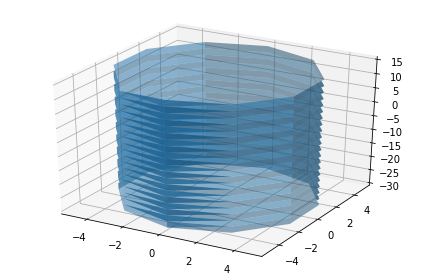

In [ ]:
imat0    = 0; # couner for material
nn12     = 0; # global beam node12 counter
mesh_struc = []
mesh_aero = []
n_struc  = 0
n_surf   = 0
monopile = [Monopile()]



if 'monopile' in data["components"].keys() and flag_foundation == 1:
    # creating structural mesh in DeSiO-Format
    if flag_foundation_struc == 1: 
        monopile[0].grid.struc.init_struc_params()
        X_R = np.hstack([ones((monopile_Struc.M+1,1))*cos_msl[0], \
                         ones((monopile_Struc.M+1,1))*cos_msl[1], \
                         ones((monopile_Struc.M+1,1))*cos_msl[2]])
        assert X_R.shape == (monopile_Struc.M+1,3), "X_R shape is wrong"
        monopile[0].grid.struc.X_RE         = monopile_Struc.arr_coordinates[:,:3] + X_R
        assert monopile[0].grid.struc.X_RE.shape[1] == 3, "X_RE shape is wrong"
        monopile[0].grid.struc.D1           = monopile_Struc.arr_coordinates[:,3:6]
        monopile[0].grid.struc.D2           = monopile_Struc.arr_coordinates[:,6:9]
        monopile[0].grid.struc.D3           = monopile_Struc.arr_coordinates[:,9:12]
        monopile[0].grid.struc.M            = monopile_Struc.M;
        monopile[0].grid.struc.connectivity = monopile_Struc.connectivity;

        monopile[0].grid.struc.matBeam.n_gl = nrb + nn12 + np.array(range(monopile_Struc.M + 1)) +1
        monopile[0].grid.struc.matBeam.inz  = np.array(range(monopile_Struc.M))
        monopile[0].grid.struc.matBeam.Cmat = monopile_Struc.arr_stiff_matrix;
        monopile[0].grid.struc.matBeam.mmat = monopile_Struc.arr_mass_matrix;
        monopile[0].grid.struc.matBeam.diss = monopile_Struc.dissipation;

        mesh_struc                             = fun_set_struc_mesh(mesh_struc,monopile)
        nmesh = len(mesh_struc)
        nmesh -= 1
        # last structure which was added named monopile
        mesh_struc[nmesh].strname = 'monopile';
        imat0                                  = mesh_struc[nmesh].imat;
        n_struc                                = n_struc + 1;
        nn12          = monopile[0].grid.struc.matBeam.n_gl[-1] - nrb;

    # creating aero grid in DeSiO-Format
    if flag_foundation_aero == 1: 
        monopile[0].grid.struc.init_aero_params()
        temp = ones(((monopile_Aero.M+1)*(2*monopile_Aero.N+1),1))
        X_R                             = np.hstack([temp * cos_msl[0], \
                                           temp * cos_msl[1], \
                                           temp * cos_msl[2]])
        monopile[0].grid.aero.X            = monopile_Aero.X_W + X_R;
        monopile[0].grid.aero.M            = monopile_Aero.M; 
        monopile[0].grid.aero.N = 2*monopile_Aero.N;
        monopile[0].grid.aero.connectivity = monopile_Aero.connectivity_w;
        monopile[0].grid.aero.node_fsi_radius = monopile_Aero.arr_node_fsi_radius

        mesh_aero = fun_set_aero_mesh(mesh_aero,monopile); 
        n_surf    = n_surf + 1
        
        fun_plot_3Dmesh('2D',mesh_aero);


    # set input for FSI
    if flag_foundation_aero == 1 and flag_foundation_struc == 1:
        if not np.any(monopile[0].grid.aero.node_fsi_radius):
            simu_fsi.data.append(['beam',n_struc,n_surf, fsi_radius_rbf])
        else:
            fsi_radius_filename = 'file_fsi_radius_' + str(n_surf) + '_input.txt'
            simu_fsi.data.append( ['beam',n_struc,n_surf, fsi_radius_filename])
            simu_fsi.data_input_node_fsi_radius.append( monopile[0].grid.aero.node_fsi_radius)


# print('mx=',vars(mesh_aero[0])['mx'],',my=',vars(mesh_aero[0])['my'],'nn=', vars(mesh_aero[0])['nn'])
# print(len(mesh_aero))

In [ ]:
print(monopile[0].grid.struc.D1.shape)

(21, 3)


In [ ]:
print(simu_fsi.data)

[['beam', 1, 1, 'file_fsi_radius_1_input.txt']]


In [ ]:
@dataclass
class Tower:
    """Class for keeping track of monopile mesh."""
    grid: Grid = Grid()

# Tower

fun_set_struc_mesh: nmesh = 1
fun_set_aero_mesh: nmesh = 1
mx= 10 ,my= 20 nn= 231
mx= 10 ,my= 40 nn= 451


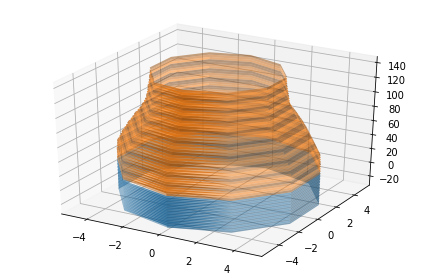

In [ ]:
n_struc = len(mesh_struc)
n_surf  = len(mesh_aero)
tower = [deepcopy(Tower())];
if 'tower' in data["components"].keys() and flag_tower == 1:
    # creating structural mesh in DeSiO-Format
    if flag_tower_struc == 1: 
        tower[0].grid.struc.init_struc_params()
        temp = ones((tower_Struc.M+1,1))
        X_R         = np.hstack([temp * cos_msl[0], \
                                temp * cos_msl[1], \
                                temp * cos_msl[2]])

        tower[0].grid.struc.X_RE         = tower_Struc.arr_coordinates[:,:3] + X_R;
        tower[0].grid.struc.D1           = tower_Struc.arr_coordinates[:,3:6]
        tower[0].grid.struc.D2           = tower_Struc.arr_coordinates[:,6:9]
        tower[0].grid.struc.D3           = tower_Struc.arr_coordinates[:,9:12]
        tower[0].grid.struc.M            = tower_Struc.M;
        tower[0].grid.struc.connectivity = tower_Struc.connectivity;

        tower[0].grid.struc.matBeam.n_gl = nrb + nn12 + \
                                        np.array(range(tower_Struc.M + 1)) + 1
        tower[0].grid.struc.matBeam.inz  = np.array(range(tower_Struc.M ))
        tower[0].grid.struc.matBeam.Cmat = tower_Struc.arr_stiff_matrix;
        tower[0].grid.struc.matBeam.mmat = tower_Struc.arr_mass_matrix;
        tower[0].grid.struc.matBeam.diss = tower_Struc.dissipation;

        mesh_struc                             = fun_set_struc_mesh(mesh_struc,tower);
        nmesh = len(mesh_struc)
        nmesh -= 1
        mesh_struc[nmesh].strname = 'tower';
        imat0                                  = mesh_struc[nmesh].imat;
        n_struc                                = n_struc + 1;
        nn12          = tower[0].grid.struc.matBeam.n_gl[-1]-nrb;


    # creating aero grid in DeSiO-Format
    if flag_tower_aero == 1: 
        tower[0].grid.struc.init_aero_params()
        temp = ones(((tower_Aero.M+1)*(2*tower_Aero.N+1),1))
        X_R                             = np.hstack([temp * cos_msl[0], \
                                           temp * cos_msl[1], \
                                           temp * cos_msl[2]])
        tower[0].grid.aero.X            = tower_Aero.X_W + X_R;
        tower[0].grid.aero.M            = tower_Aero.M; 
        tower[0].grid.aero.N = 2*tower_Aero.N;
        tower[0].grid.aero.connectivity = tower_Aero.connectivity_w;
        tower[0].grid.aero.node_fsi_radius = tower_Aero.arr_node_fsi_radius

        mesh_aero = fun_set_aero_mesh(mesh_aero,tower); 
#         print('mx=',vars(mesh_aero[0])['mx'],',my=',vars(mesh_aero[0])['my'],'nn=', vars(mesh_aero[0])['nn'])
#         print('mx=',vars(mesh_aero[1])['mx'],',my=',vars(mesh_aero[1])['my'],'nn=', vars(mesh_aero[1])['nn'])
        n_surf    = n_surf + 1

        fun_plot_3Dmesh('2D',mesh_aero);

    # set input for FSI
    if flag_tower_aero == 1 and flag_tower_struc == 1:
        if not np.any(tower[0].grid.aero.node_fsi_radius):
            simu_fsi.data.append(['beam',n_struc,n_surf, fsi_radius_rbf])
        else:
            fsi_radius_filename = 'file_fsi_radius_' + str(n_surf) + '_input.txt'
            simu_fsi.data.append( ['beam',n_struc,n_surf, fsi_radius_filename])
            simu_fsi.data_input_node_fsi_radius.append( tower[0].grid.aero.node_fsi_radius)
print('mx=',vars(mesh_aero[0])['mx'],',my=',vars(mesh_aero[0])['my'],'nn=', vars(mesh_aero[0])['nn'])
print('mx=',vars(mesh_aero[1])['mx'],',my=',vars(mesh_aero[1])['my'],'nn=', vars(mesh_aero[1])['nn'])

In [ ]:
print(simu_fsi.data)

[['beam', 1, 1, 'file_fsi_radius_1_input.txt'], ['beam', 2, 2, 'file_fsi_radius_2_input.txt']]


# Blades

In [ ]:
@dataclass
class RotorData:
    @dataclass
    class RotorDataAero:
        X_C:np.array = np.array([])
        X_W:np.array = np.array([])
    @dataclass
    class RotorDataStruc:
        X_RE:np.array = np.array([])
        D1:np.array = np.array([])
        D2:np.array = np.array([])
        D3:np.array = np.array([])
        matBeam:MatProp = MatProp()
    aero:RotorDataAero = RotorDataAero(  X_C = np.array([])
                         , X_W  = np.array([]))
    struc:RotorDataStruc = RotorDataStruc(X_RE = np.array([]), 
                            D1 = np.array([]), 
                            D2 = np.array([]), 
                            D3 = np.array([]),  
                            matBeam = MatProp())

In [ ]:
def  fun_blades2rotor(blade_aero, blade_struc, n_pitch, a_pitch, n_rotor, a_rotor, n_tilt, a_tilt, x_r):
    # translating, pitching and rotating of blade to bring in rotor position
    # rotation matrix around pitch axis
    assert n_pitch.ndim == 2, "n_pitch must be 1x3"
    assert n_rotor.ndim == 2, "n_rotor must be 1x3"
    assert n_tilt.ndim == 2, "n_tilt must be 1x3"
    Rp = cos(a_pitch*pi/180)*eye(3) + \
        sin(a_pitch*pi/180)*skew(n_pitch)+\
            (1-cos(a_pitch*pi/180))*n_pitch.T@n_pitch
    # rotation matrix around rotor axis
    Rr = cos(a_rotor*pi/180)*eye(3) + \
        sin(a_rotor*pi/180)*skew(n_rotor)+\
            (1-cos(a_rotor*pi/180))*n_rotor.T @ n_rotor;
    # rotation matrix around tilt
    Rt = cos(a_tilt*pi/180)*eye(3) + \
        sin(a_tilt*pi/180)*skew(n_tilt)+\
            (1-cos(a_tilt*pi/180))*n_tilt.T @ n_tilt;

    # print(f'Rr = {Rr}')
    # print(f'Rp = {Rp}')
    # print(f'Rt = {Rt}')
    # calculate new position vector for aero grid in global cos
    nnodes = (blade_aero.M+1)*(blade_aero.N+1);
    temp = ones((nnodes,1))
    X_R = np.hstack([ temp * x_r[0],
                        temp * x_r[1],
                        temp * x_r[2]])
    blade_ro_cos = RotorData()
    blade_ro_cos.aero.X_C  = (Rt @ Rr @ (Rp @ blade_aero.X_C.T + X_R.T)).T

    nnodes = (blade_aero.M+1)*(2*blade_aero.N+1);
    temp = ones((nnodes,1))
    X_R = np.hstack([ temp * x_r[0],
                        temp * x_r[1],
                        temp * x_r[2]])
    blade_ro_cos.aero.X_W  = (Rt @ Rr @ (Rp @ blade_aero.X_W.T + X_R.T)).T

    nnodes = (blade_struc.M+1);
    temp = ones((nnodes,1))
    X_R = np.hstack([ temp * x_r[0],
                        temp * x_r[1],
                        temp * x_r[2]])
    
    blade_ro_cos.struc.X_RE = (Rt @ Rr @ \
                                (Rp @ blade_struc.arr_coordinates[:,:3].T \
                                     + X_R.T)).T
    blade_ro_cos.struc.D1 = (Rt @ Rr @ Rp @ \
                                blade_struc.arr_coordinates[:, 3:6].T).T
    blade_ro_cos.struc.D2 = (Rt @ Rr @ Rp @ \
                                blade_struc.arr_coordinates[:, 6:9].T).T
    blade_ro_cos.struc.D3 = (Rt @ Rr @ Rp @ \
                                blade_struc.arr_coordinates[:,9:12].T).T
    return blade_ro_cos

In [ ]:
from copy import copy
@dataclass
class WakeObj:
    inf:np.array = np.array([])
    nsurf:int = 0
    nsegments:int = 0
    nproperty:int = 0
@dataclass
class Wake:
    
    wakes:List[WakeObj] = field(default_factory=lambda: [WakeObj()])
    property:np.array = np.empty((1,3)) 
# TODO: This needs to be changed
def   fun_blade_wake(wake, wakesurf, obj, tnrows, nrows, wake_diffusion):
    logging.info('inside fun_blade_wake')
    # define seperation edge
    if not wake:
        w = 0
        wake = Wake()
        wake.wakes.append(deepcopy(wake.wakes[0]))
        wake.property = np.append(wake.property, [[-1,-1,-1]], axis=0)
        logging.debug(f'wake was empty, creating new wake')
        logging.debug(f'wake index: w = {w}')
        logging.debug(f'type(wake.wakes) = {type(wake.wakes)}')
        logging.debug(f'len(wake.wakes) = {len(wake.wakes)}')
    else:
        w = len(wake.wakes)
        logging.debug(f'wake was not empty, appending new wake')
        logging.debug(f'wake index: w = {w}')
        wake.wakes.append(deepcopy(wake.wakes[0]))
        wake.property = np.append(wake.property, [[-1,-1,-1]], axis=0)
        wake.wakes.append(deepcopy(wake.wakes[0]))
        wake.property = np.append(wake.property, [[-1,-1,-1]], axis=0)
        logging.debug(f'wake property.shape: {wake.property.shape}')
    
    
    
    a = 0;
    # logging.debug(f'(obj.mx+1) = {obj.mx+1}')
    # logging.debug(f'(obj.mx+1)*(obj.my+1)-1 = {(obj.mx+1)*(obj.my+1)-1}')
    # logging.debug(f'obj.connectivity.shape = {obj.connectivity.shape}')
    # logging.info('For loop started')
    iter_ = np.arange( (obj.mx+1)-1,(obj.mx+1)*(obj.my+1)-1, (obj.mx+1))
    wake.wakes[w].inf = np.zeros((len(iter_), 3))
    connectivity = copy(obj.connectivity)
    connectivity = connectivity.flatten('F')
    for j in iter_:
        
        # logging.debug(f'j = {j}, j+(obj.mx+1) = {j+(obj.mx+1)}')
        temp = np.argwhere(obj.connectivity == j)
        row1 = temp[:,0]
        # logging.debug(f'obj.connectivity[row1,:] = {obj.connectivity[row1,:]}')
        temp = np.argwhere(obj.connectivity[row1,:] == j+(obj.mx+1))
        row2 = temp[:,0]
        
        if not row2: 
            row2 = 0
        # logging.debug(f'j= {j}, row1 = {row1}')
        # logging.debug(f'j= {j}, row2 = {row2}')
        # logging.debug(f'j= {j}, row1[row2] = {row1[row2]}')
        wake.wakes[w].inf[a,:] = np.array([j,j+obj.mx+1, row1[row2]]) 
        a = a + 1;
    
    # logging.info('For loop ended')
    wake.wakes[w].nsurf     = wakesurf;
    wake.wakes[w].nsegments = a;
    wake.wakes[w].nproperty = w +1;

    # define wake properties
    wake.property[w,:3] = [tnrows,nrows, wake_diffusion];
    # wake at blade tip
    a = 0;
    iter_ = np.arange((obj.mx+1)*(obj.my+1)-1,(obj.mx+1)*obj.my+1+1,-1)
    # logging.debug(f'wake.wakes[w+1].inf = {wake.wakes[w+1].inf}')
    # logging.debug(f'type(wake.wakes[w+1].inf) = {type(wake.wakes[w+1].inf)}')
    wake.wakes[w+1].inf = np.zeros((len(iter_), 3))
    # logging.debug(f'obj.connectivity[:,-1] = {obj.connectivity[:,-1]}')
    for j in iter_:
        # logging.debug(f'j = {j}')
        # logging.debug(f'j = {j}, j+(obj.mx+1) = {j+(obj.mx+1)}')
        temp = np.argwhere(obj.connectivity == j)
        row1 = temp[:,0]
        # logging.debug(f'obj.connectivity[row1,:] = {obj.connectivity[row1,:]}')
        temp = np.argwhere(obj.connectivity[row1,:] == j-1)
        row2 = temp[:,0]
        if not row2: 
            row2 = 0
        # logging.debug(f'row1 = {row1}')
        # logging.debug(f"[j,j-1, row1[row2]] = {[j,j-1, row1[row2]]}")
        wake.wakes[w+1].inf[a,:] = np.array([j,j-1, row1[row2]])
        a = a + 1;
    wake.wakes[w+1].nsurf     = wakesurf;
    wake.wakes[w+1].nsegments = a;
    wake.wakes[w+1].nproperty = w + 1;
    wake.property[w+1,:3] = [tnrows,nrows, wake_diffusion];
    logging.info('fun_blade_wake done')
    return wake
# wake = []
# wake = fun_blade_wake(wake,
#                                     n_surf + len(blade_obj),
#                                     mesh_aero[n_surf + len(blade_obj)-1],
#                                     data["simulationparamter"]["nwakerows"],
#                                     data["simulationparamter"]["nwakerows"]);

In [ ]:
from typing import Any
class Helpers:
    def __init__(self):
        pass
    @staticmethod
    def hstack( temp, x_r):
        if x_r.ndim ==2:
            x_r = x_r.flatten()
        return np.hstack([ temp * x_r[0], \
                            temp * x_r[1], \
                                temp * x_r[2]])
    @staticmethod
    def try_append(obj:List, idx:int, value:Any):
        try: 
            obj[idx] = value
        except IndexError:
            obj.append(value)
        return obj
utils = Helpers()

In [ ]:
from copy import deepcopy
@dataclass
class Blade:
    """Class for blade data"""
    def __init__(self) -> None:
        struc = deepcopy(MeshInfo(M=0,
                         N=0,
                         connectivity=np.array([])))
        self.grid: Grid = deepcopy(Grid(struc=struc, aero=struc))
    def __repr__(self) -> str:
        return f"Blade: {self.grid}"

@dataclass
class BladeAero:
    X:np.array = np.array([])
    connectivity:np.array = np.array([])
    M:int = 0
    N:int = 0
@dataclass
class Blade2:

    @dataclass
    class BladeGrid:
        aero:BladeAero = BladeAero(X = np.array([]),
                                  connectivity = np.array([]),
                                  M = 0,
                                  N = 0)
    temp = BladeAero(X = np.array([]),
                                  connectivity = np.array([]),
                                  M = 0,
                                  N = 0)
    grid:BladeGrid = BladeGrid(aero = temp)

nbl = 0; imatb = imat0;
blades = [deepcopy(Blade()) for i in range(n_blades)]
blade_obj = []
wake = []
if 'blade' in data["components"] and flag_blade == 1:
    ir1    = -i2 
    ir2    =  i1
    ir3    =  i3

    # Blade root and rest of the blade
    nn = 0; 
    ne = 0; 
    inz_blade_root = [];
    if blade_Aero.nbr != 0:
        # getting indices for extracting blade root from arrays
        arr_inz_airfoil = blade_Aero.arr_inz_airfoil;
        inz = np.nonzero(arr_inz_airfoil<=blade_Aero.nbr -1)[0]
        inz_blade_root = np.array(range(inz[-1]+2)) 

        M_br = len(inz_blade_root)-1;
        N_br = 2*blade_Aero.N;

        nn_br = (M_br+1)*(blade_Aero.N+1);
        ne_br = M_br*blade_Aero.N;
        for i  in range(n_blades):
            n_struc = len(mesh_struc);
            n_surf  = len(mesh_aero);

            # position angle of blade i in rotor
            alpha_blades = (i)*2*np.pi/n_blades*180/np.pi;

            # positioning blade in rotor
            blades[i].grid = deepcopy(fun_blades2rotor(blade_Aero, 
                                                blade_Struc, 
                                                ir3, 
                                                -pitch_angle, 
                                                ir2, 
                                                alpha_blades, 
                                                n_tilt, 
                                                uptilt_angle*180/pi, 
                                                [0,0,hub_diameter/2])); 


            
            # creating structural mesh in DeSiO-Format
            if flag_blade_struc == 1:
                nbl = blade_Struc.M+1;
                temp = ones((blade_Struc.M+1,1))
                X_R = np.hstack([temp * cos_hc[0,0],
                                temp * cos_hc[0,1],
                                temp * cos_hc[0,2]])


                blades[i].grid.struc.X_RE = blades[i].grid.struc.X_RE + X_R;
                blades[i].grid.struc.M = blade_Struc.M;
                blades[i].grid.struc.connectivity = blade_Struc.connectivity;
#                 print(f'nrb = {nrb}')
#                 print(f'nn12 = {nn12}')
#                 print(f'nbl = {nbl}')
#                 print(f'np.array(range(nbl)) = {np.array(range(nbl))}')
                blades[i].grid.struc.matBeam.n_gl = (nrb+1) + nn12 + \
                                                    (i)*nbl + np.array(range(nbl))
                # logging.debug(f'blades[{0}].grid.struc.matBeam.n_gl = {blades[0].grid.struc.matBeam.n_gl}')
                logging.debug(f'blades[{i}].grid.struc.matBeam.n_gl = {blades[i].grid.struc.matBeam.n_gl}')
                blades[i].grid.struc.matBeam.inz  = np.array(range(blade_Struc.M))
                blades[i].grid.struc.matBeam.Cmat = blade_Struc.arr_stiff_matrix
                blades[i].grid.struc.matBeam.mmat = blade_Struc.arr_mass_matrix
                blades[i].grid.struc.matBeam.diss = blade_Struc.dissipation

                mesh_struc = fun_set_struc_mesh(mesh_struc,[blades[i]]);
                nmesh = len(mesh_struc)
                nmesh -= 1
                mesh_struc[nmesh].strname = 'blade ' + str(i)
                mesh_struc[nmesh].imat = imatb;

                n_struc = n_struc + 1;
                nbl = n_blades*nbl;

            
            # creating aero grid in DeSiO-Format
            if flag_blade_aero == 1:

                temp = ones(((blade_Aero.M+1)*(blade_Aero.N+1),1))
                X_R = utils.hstack(temp, cos_hc)
                
                X_C = blades[i].grid.aero.X_C  + X_R

                temp = ones(((blade_Aero.M+1)*(2*blade_Aero.N+1),1))
                X_R = utils.hstack(temp, cos_hc)
                X_W = blades[i].grid.aero.X_W  + X_R;

                # Blade root and rest of the blade
                if len(blade_obj)<2:
                    logging.info(f'i = {i},len(blade_obj) = {len(blade_obj)}')
                    # there are only two blades
                    blade_obj.append(deepcopy(Blade2()))
                if blade_Aero.nbr != 0:
                    #print(f'blade_obj[0].grid.aero.N = {blade_obj[0].grid.aero.N}')
                    # extracting blade root from arrays
                    blade_obj[0].grid.aero.N = N_br;
                    
                    blade_obj[0].grid.aero.M = M_br;
                    blade_obj[0].grid.aero.X = X_W[:(N_br+1)*(M_br+1),:]
                    blade_obj[0].grid.aero.connectivity = \
                                blade_Aero.connectivity_w[:M_br*N_br,:]
                    # TODO: check if this is correct
                    blade_obj[0].grid.aero.node_fsi_radius = blade_Aero.arr_node_fsi_radius_w[:(N_br+1)*(M_br+1)]

                    
                    if len(blade_obj)<2:
                        logging.info(f'i = {i},len(blade_obj) = {len(blade_obj)}')
                        # there are only two blades
                        blade_obj.append(deepcopy(Blade2()))
                    # extracting rest of blade from arrays
                    
                    blade_obj[1].grid.aero.N = blade_Aero.N;
                    blade_obj[1].grid.aero.M = blade_Aero.M-M_br;
#                     print('X_C=',X_C)
                    blade_obj[1].grid.aero.X = X_C[(nn_br-blade_Aero.N-1):,:]
                    blade_obj[1].grid.aero.connectivity = blade_Aero.connectivity_c[ne_br:,:]-(nn_br-blade_Aero.N)+1;
                    blade_obj[1].grid.aero.node_fsi_radius = blade_Aero.arr_node_fsi_radius_w[:(N_br+1)*(M_br+1)]
                else:
                    blade_obj[0].grid.aero.N = blade_Aero.N;
                    blade_obj[0].grid.aero.M = blade_Aero.M;
                    blade_obj[0].grid.aero.X = X_C;
                    blade_obj[0].grid.aero.connectivity = blade_Aero.connectivity_c;
                    blade_obj[0].grid.aero.node_fsi_radius = blade_Aero.arr_node_fsi_radius


                
                # creating mesh in DeSiO-Format
                # print('mx=',vars(mesh_aero[0])['mx'],',my=',vars(mesh_aero[0])['my'],'nn=', vars(mesh_aero[0])['nn'])
                # print('mx=',vars(mesh_aero[1])['mx'],',my=',vars(mesh_aero[1])['my'],'nn=', vars(mesh_aero[1])['nn'])
                
                mesh_aero = fun_set_aero_mesh(mesh_aero,blade_obj);
                print(f'len(mesh_aero) = {len(mesh_aero)}')
                for obj in mesh_aero:
                    if hasattr(obj, 'imat'):
                        # print(f'obj.__dict__ = {obj.__dict__}')
                        if 'imat' in obj.__dict__.keys():
                            delattr(obj,'imat')
                            # del obj.__dict__['imat']
                    if hasattr(obj, 'strname'):
                        if 'strname' in obj.__dict__.keys():
                            delattr(obj,'strname')
                            # del obj.__dict__['strname']
                
                # start troubleshooting from line 396 before that it's correct

                # logging.debug('Inputs to fun_blade_wake')
                # logging.debug(f'n_surf + len(blade_obj)= {n_surf + len(blade_obj)}')
                # logging.debug(f'data["simulationparamter"]["nwakerows"] = {data["simulationparamter"]["nwakerows"]}')
                # logging.debug(f'wake = {wake}')
                # logging.debug(f'mesh_aero[n_surf + len(blade_obj)-1] = {mesh_aero[n_surf + len(blade_obj)-1]}')
                # logging.debug('Inputs to fun_blade_wake end')
                wake = fun_blade_wake(wake,
                                    n_surf + len(blade_obj),
                                    mesh_aero[n_surf + len(blade_obj)-1],
                                    data["simulationparamter"]["nwakerows"],
                                    data["simulationparamter"]["nwakerows"],
                                    wake_diffusion);
                

            
            # setting input for FSI
            if flag_blade_aero == 1 and flag_blade_struc == 1:
                logging.debug('Setting input for FSI')
                logging.debug(f'len(blade_obj) = {len(blade_obj)}')
                for j in range(len(blade_obj)):
                    if not np.any(blade_obj[j].grid.aero.node_fsi_radius):
                        simu_fsi.data.append(['beam',n_struc,n_surf+j+1, fsi_radius_rbf])
                    else:
                        fsi_radius_filename = 'file_fsi_radius_' + str(n_surf+j) + '_input.txt'
                        simu_fsi.data.append( ['beam',n_struc,n_surf+j, fsi_radius_filename])
                        simu_fsi.data_input_node_fsi_radius.append( blade_obj[j].grid.aero.node_fsi_radius)
                    

logging.debug(f'len(simu_fsi.data) = {len(simu_fsi.data)}')
logging.debug(f'simu_fsi.data = {simu_fsi.data}')


fun_set_struc_mesh: nmesh = 2
fun_set_aero_mesh: nmesh = 2
len(mesh_aero) = 4
fun_set_struc_mesh: nmesh = 3
fun_set_aero_mesh: nmesh = 4
len(mesh_aero) = 6
fun_set_struc_mesh: nmesh = 4
fun_set_aero_mesh: nmesh = 6
len(mesh_aero) = 8


<ipython-input-172-114ab8cecb0b>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wake.wakes[w].inf[a,:] = np.array([j,j+obj.mx+1, row1[row2]])


# Additional Masses

In [ ]:
logging.info("Additional masses sections")
logging.info("*"*50)
nam = 0;
if monopile and flag_foundation_struc == 1:
	simu_struct.pointmass12.append(deepcopy(simu_struct.pointmass))
	simu_struct.pointmass12[nam].mass = tp_mass;
	simu_struct.pointmass12[nam].node = monopile[0].grid.struc.matBeam.n_gl[-1];
	nam = nam + 1;

# additional mass for yaw bearing at tower top
if 'nacelle' in data["components"].keys() and flag_nacelle == 1:
	if tower and flag_tower_struc == 1:
		simu_struct.pointmass12.append(deepcopy(simu_struct.pointmass))
		simu_struct.pointmass12[nam].mass = yaw_mass;
		simu_struct.pointmass12[nam].node = tower[0].grid.struc.matBeam.n_gl[-1];
		nam = nam + 1;
	

In [ ]:
logging.debug(f'len(simu_struct.pointmass12) = {len(simu_struct.pointmass12)}')
logging.debug(f'simu_struct.pointmass12 = {simu_struct.pointmass12}')

# CONSTRAINTS

In [ ]:
logging.info("Additional masses sections end")
logging.info("*"*50)
logging.info("Constraints sections")
logging.info("*"*50)
simu_struct.constraints = [];
remo_internal_const = [];
nco = 0;
if tower and flag_tower_struc == 1:
    if monopile and flag_foundation_struc == 1:
        
        simu_struct.constraints = utils.try_append(simu_struct.constraints, 
                                                    nco,
                                                    deepcopy(simu_struct.constraint), 
                                                    )
        # simu_struct.constraints.append(deepcopy(simu_struct.constraint))
        simu_struct.constraints[nco].type  = 'rigidsupport'
        simu_struct.constraints[nco].nodes = np.array([monopile[0].grid.struc.matBeam.n_gl[0], 0])
        simu_struct.constraints[nco].phi1 = []
        simu_struct.constraints[nco].phi2 = []
        simu_struct.constraints[nco].dir = []
        remo_internal_const = utils.try_append(remo_internal_const,
                                                nco,
                                                monopile[0].grid.struc.matBeam.n_gl[0]
                                                )
        nco = nco + 1;
        
        
        
        simu_struct.constraints = utils.try_append(simu_struct.constraints, 
                                                    nco,
                                                    deepcopy(simu_struct.constraint), 
                                                    )
        
        simu_struct.constraints[nco].type  = 'rigidconnection';
        simu_struct.constraints[nco].nodes = np.array([monopile[0].grid.struc.matBeam.n_gl[-1], tower[0].grid.struc.matBeam.n_gl[0]])
        simu_struct.constraints[nco].phi1 = []
        simu_struct.constraints[nco].phi2 = []
        simu_struct.constraints[nco].dir = []
        remo_internal_const = utils.try_append(remo_internal_const,
                                                nco,
                                                monopile[0].grid.struc.matBeam.n_gl[-1]
                                                )
        nco = nco + 1;
        # remo_internal_const.append(monopile[0].grid.struc.matBeam.n_gl[-1] )
    else:
        
        simu_struct.constraints = utils.try_append(simu_struct.constraints, 
                                                    nco,
                                                    deepcopy(simu_struct.constraint), 
                                                    )
        simu_struct.constraints[nco].type  = 'rigidsupport';
        simu_struct.constraints[nco].nodes = np.array([tower[0].grid.struc.matBeam.n_gl[0], 0])
        simu_struct.constraints[nco].phi1 = []
        simu_struct.constraints[nco].phi2 = []
        simu_struct.constraints[nco].dir = []
        remo_internal_const = utils.try_append(remo_internal_const,
                                                nco,    
                                                tower[0].grid.struc.matBeam.n_gl[0]
                                                )
        nco = nco + 1;
        # remo_internal_const.append( tower[0].grid.struc.matBeam.n_gl[0])
        
    if 'nacelle' in data["components"] and flag_nacelle == 1:
        
        simu_struct.constraints = utils.try_append(simu_struct.constraints, 
                                                    nco,
                                                    deepcopy(simu_struct.constraint), 
                                                    )
        simu_struct.constraints[nco].type  = 'rigidconnection';
        simu_struct.constraints[nco].nodes = np.array([tower[0].grid.struc.matBeam.n_gl[-1], nnac])
        
        #             phi1 = nacelle_centerm_tt;
        simu_struct.constraints[nco].phi1 = []
        simu_struct.constraints[nco].phi2 = []
        simu_struct.constraints[nco].dir = []
        remo_internal_const = utils.try_append(remo_internal_const,
                                                nco,
                                                tower[0].grid.struc.matBeam.n_gl[-1]
                                                )
        nco = nco + 1
        # remo_internal_const.append( tower[0].grid.struc.matBeam.n_gl[-1])

In [ ]:
logging.debug(f'len(simu_struct.constraints) = {len(simu_struct.constraints)}')
logging.debug(f'simu_struct.constraints = {simu_struct.constraints}')
logging.debug(f'remo_internal_const = {remo_internal_const}')

In [ ]:
if "hub" in data["components"] and flag_hub == 1:
    if "nacelle" in data["components"] and flag_nacelle == 1:
        
        nhub = nnac + 1;
        simu_struct.constraints = utils.try_append(simu_struct.constraints, 
                                                    nco,
                                                    deepcopy(simu_struct.constraint), 
                                                    )
        simu_struct.constraints[nco].type  = 'revolutejoint';

        simu_struct.constraints[nco].nodes = np.array([nnac, nhub])
        # simu_struct.constraints[nco].dir  = np.array([e_shaft @ simu_struct.rb[nnac].D1.T, 
        #                                     e_shaft @ simu_struct.rb[nnac].D2.T, 
        #                                     e_shaft @ simu_struct.rb[nnac].D3.T])

        simu_struct.constraints[nco].dir  = []
        #          phi1 = [cos_tt + shaft_rb2_tt] - simu_struct.rb[nnac].center_mass ;
        if cos_tt.ndim == 1:
            cos_tt = np.expand_dims(cos_tt, axis=0)
        phi1 = cos_tt + shaft_rb1_tt - simu_struct.rb[nnac].center_mass ;
        simu_struct.constraints[nco].phi1 = np.array([phi1 @ simu_struct.rb[nnac].D1.T, 
                                                    phi1 @ simu_struct.rb[nnac].D2.T, 
                                                    phi1 @ simu_struct.rb[nnac].D3.T])

        logging.debug(f'phi1 = {phi1}')
        phi2 = cos_tt + shaft_rb2_tt - simu_struct.rb[nhub].center_mass;
        logging.debug(f'cos_tt = {cos_tt}')
        logging.debug(f'shaft_rb2_tt = {shaft_rb2_tt}')
        logging.debug(f'simu_struct.rb[nhub].center_mass = {simu_struct.rb[nhub].center_mass}')
        simu_struct.constraints[nco].phi2 = np.array([phi2 @ simu_struct.rb[nhub].D1.T, 
                                                    phi2 @ simu_struct.rb[nhub].D2.T, 
                                                    phi2 @ simu_struct.rb[nhub].D3.T])
        logging.debug(f'phi2 = {phi2}')
        logging.debug(f'simu_struct.constraints[{nco}] = {simu_struct.constraints[nco]}')
        # rotor rotation axis in global cos and local hub cos:
        #TODO: check if this is correct
        dir_gl = simu_struct.rb[nhub].center_mass - \
                    (simu_struct.rb[nnac].center_mass + phi1)
        dir_gl = dir_gl/norm(dir_gl);
        dir_lo = np.array([ dir_gl @ simu_struct.rb[nhub].D1.T, 
                    dir_gl @ simu_struct.rb[nhub].D2.T, 
                    dir_gl @ simu_struct.rb[nhub].D3.T])
        nco  = nco + 1;
     
    

In [ ]:
if blades and flag_blade_struc == 1:
    if "hub" in data["components"].keys() and flag_hub == 1:
        nco0 = nco;
        j_temp =1
        for i in range(n_blades):
            
            nhub = nnac + 1;
            simu_struct.constraints = utils.try_append(simu_struct.constraints,
                                                        nco,
                                                        deepcopy(simu_struct.constraint),
                                                        )
            simu_struct.constraints[nco].type  = 'rigidconnection';
            simu_struct.constraints[nco].nodes = np.array([nhub, blades[i].grid.struc.matBeam.n_gl[0]])
            # TODO: check if this is correct
            simu_struct.constraints[nco].phi1  = np.array([0,0,0])
            logging.debug(f'simu_struct.constraints[{nco}].nodes = {simu_struct.constraints[nco].nodes}')
            
#                 phi1 = blades[i].grid.struc.X_RE[0,:] - simu_struct.rb[nhub].center_mass;
            phi1 = np.array([[0,0,0]]);
            simu_struct.constraints[nco].phi1 = np.array([phi1 @ simu_struct.rb[nhub].D1.T, 
                                                phi1 @ simu_struct.rb[nhub].D2.T, 
                                                phi1 @ simu_struct.rb[nhub].D3.T])
            simu_struct.constraints[nco].phi2 = []
            simu_struct.constraints[nco].dir = []

            remo_internal_const = utils.try_append(remo_internal_const,
                                                nco,
                                                blades[i].grid.struc.matBeam.n_gl[0]
                                                )
            logging.debug(f'simu_struct.constraints[{nco}] = {simu_struct.constraints[nco]}')
            nco  = nco0 + j_temp ;
            j_temp += 1
        nco += 1
        logging.debug(f'remo_internal_const = {remo_internal_const}')
        if (not tower) or (flag_tower_struc == 0):
            # TODO: check if this is correct
            simu_struct.constraints = utils.try_append(simu_struct.constraints,
                                                        nco,
                                                        deepcopy(simu_struct.constraint),
                                                        )
            simu_struct.constraints[nco].type  = 'sphericalsupport';
            simu_struct.constraints[nco].nodes = np.array([nhub, 0])
            simu_struct.constraints[nco].phi1 = []
            simu_struct.constraints[nco].phi2 = []
            simu_struct.constraints[nco].dir = []
            nco = nco + 1;
            simu_struct.constraints = utils.try_append(simu_struct.constraints,
                                                        nco,
                                                        deepcopy(simu_struct.constraint),
                                                        )
            simu_struct.constraints[nco].type  = 'rotation_global';
            simu_struct.constraints[nco].nodes = np.array([nhub, 0])
            simu_struct.constraints[nco].dir   = np.array([[0.00,1.00,0.00]])
            simu_struct.constraints[nco].phi1 = []
            simu_struct.constraints[nco].phi2 = []
            nco = nco + 1;
            simu_struct.constraints = utils.try_append(simu_struct.constraints,
                                                        nco,
                                                        deepcopy(simu_struct.constraint),
                                                        )
            simu_struct.constraints[nco].type  = 'rotation_global';
            simu_struct.constraints[nco].nodes = np.array([nhub, 0])
            simu_struct.constraints[nco].dir   = np.array([[0.00,0.00,1.00]])
            simu_struct.constraints[nco].phi1 = []
            simu_struct.constraints[nco].phi2 = []
            nco = nco + 1;

        # if n_blades == 0:
        #     # TODO: check if this is correct
        #     simu_struct.constraints = utils.try_append(simu_struct.constraints,
        #                                                 nco,
        #                                                 deepcopy(simu_struct.constraint),
        #                                                 )
        #     simu_struct.constraints[nco].type  = 'rigidsupport';
        #     simu_struct.constraints[nco].nodes = np.array([blades[0].grid.struc.matBeam.n_gl[0], 0])
        #     simu_struct.constraints[nco].phi1 = []
        #     simu_struct.constraints[nco].phi2 = []
        #     simu_struct.constraints[nco].dir = []
        #     remo_internal_const = utils.try_append(remo_internal_const,
        #                                         nco,
        #                                         blades[0].grid.struc.matBeam.n_gl[0]
        #                                         )
        #     nco  = nco + 1;

In [ ]:
logging.debug(f'len(simu_struct.constraints) = {len(simu_struct.constraints)}')
logging.debug(f'simu_struct.constraints = {simu_struct.constraints}')

In [ ]:
nn = nrb + nn12 + nbl + 1; 
nodes = np.array(range(nn))
ai = len(simu_struct.constraints)
for i in range(nn):
    if all(remo_internal_const-nodes[i]):
        simu_struct.constraints = utils.try_append(simu_struct.constraints,
                                                    ai,
                                                    deepcopy(simu_struct.constraint),
                                                    )
        simu_struct.constraints[ai].type  = 'internal';
        simu_struct.constraints[ai].nodes = np.array([nodes[i], 0])
        simu_struct.constraints[ai].phi1 = []
        simu_struct.constraints[ai].phi2 = []
        simu_struct.constraints[ai].dir = []
        logging.debug(f'simu_struct.constraints[{ai}] = {simu_struct.constraints[ai]}')
        
        ai = ai + 1;
   

In [ ]:
if monopile and flag_foundation_struc == 1:
    for i in range(monopile[0].grid.struc.matBeam.Cmat.shape[0]):
        simu_struct.matbeam = utils.try_append(simu_struct.matbeam,
                                                i,
                                                deepcopy(simu_struct.materialbeam),
                                                )
        simu_struct.matbeam[i].cmat    = monopile[0].grid.struc.matBeam.Cmat[i,:];
        simu_struct.matbeam[i].mmat    = monopile[0].grid.struc.matBeam.mmat[i,:];
        simu_struct.matbeam[i].diss    = monopile[0].grid.struc.matBeam.diss;
        simu_struct.matbeam[i].strname = 'monopile';
    imat = i;
    logging.debug(f'simu_struct.matbeam = {simu_struct.matbeam}')
    logging.debug(f'len(simu_struct.matbeam) = {len(simu_struct.matbeam)}')
    logging.debug(f'len(simu_struct.matbeam[i].cmat) = {len(simu_struct.matbeam[0].cmat)}')
    logging.debug(f'len(simu_struct.matbeam[i].mmat) = {len(simu_struct.matbeam[0].mmat)}')
    logging.debug(f'len(simu_struct.matbeam[i].diss) = {len(simu_struct.matbeam[0].diss)}')
    logging.debug(f'simu_struct.matbeam[i].strname = {simu_struct.matbeam[0].strname}')

In [ ]:
print(imat)
print(len(simu_struct.matbeam))

19
20


In [ ]:
imat += 1
# TODO: check if this is correct
if tower and flag_tower_struc == 1:
    for i in range(tower[0].grid.struc.matBeam.Cmat.shape[0]):
        simu_struct.matbeam = utils.try_append(simu_struct.matbeam,
                                                i+imat,
                                                deepcopy(simu_struct.materialbeam),
                                                )
        simu_struct.matbeam[i+imat].cmat    = tower[0].grid.struc.matBeam.Cmat[i,:];
        simu_struct.matbeam[i+imat].mmat    = tower[0].grid.struc.matBeam.mmat[i,:];
        simu_struct.matbeam[i+imat].diss    = tower[0].grid.struc.matBeam.diss;
        simu_struct.matbeam[i+imat].strname = 'tower';
    imat = i + imat;
    logging.debug(f'simu_struct.matbeam = {simu_struct.matbeam}')
    logging.debug(f'len(simu_struct.matbeam) = {len(simu_struct.matbeam)}')
    logging.debug(f'len(simu_struct.matbeam[i].cmat) = {len(simu_struct.matbeam[0].cmat)}')
    logging.debug(f'len(simu_struct.matbeam[i].mmat) = {len(simu_struct.matbeam[0].mmat)}')
    logging.debug(f'len(simu_struct.matbeam[i].diss) = {len(simu_struct.matbeam[0].diss)}')
    logging.debug(f'simu_struct.matbeam[i].strname = {simu_struct.matbeam[0].strname}')

In [ ]:
imat += 1
# TODO: check if this is correct
if blades and flag_blade_struc == 1:      
    for i in range(blades[0].grid.struc.matBeam.Cmat.shape[0]):
        simu_struct.matbeam = utils.try_append(simu_struct.matbeam,
                                                i+imat,
                                                deepcopy(simu_struct.materialbeam),
                                                )
        simu_struct.matbeam[i+imat].cmat = blades[0].grid.struc.matBeam.Cmat[i,:];
        simu_struct.matbeam[i+imat].mmat = blades[0].grid.struc.matBeam.mmat[i,:];
        simu_struct.matbeam[i+imat].diss = blades[0].grid.struc.matBeam.diss;
        simu_struct.matbeam[i+imat].strname = 'blade';
    logging.debug(f'simu_struct.matbeam = {simu_struct.matbeam}')
    logging.debug(f'len(simu_struct.matbeam) = {len(simu_struct.matbeam)}')
    logging.debug(f'len(simu_struct.matbeam[i].cmat) = {len(simu_struct.matbeam[0].cmat)}')
    logging.debug(f'len(simu_struct.matbeam[i].mmat) = {len(simu_struct.matbeam[0].mmat)}')


# WRITING DESIO-INPUT FILES

In [ ]:
print(tower[0].grid.struc.matBeam.Cmat.shape[0])
print(len(monopile))

40
1


# # start troubleshooting from line 591 before that it's correct

In [ ]:
!pip install path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import shutil
import os
from os.path import exists
import re
from path import Path
import glob

In [ ]:
def fun_writeDeSiOAeroInput(simu,mesh,wake):
    """ Write the input file for DeSiOAero
    """
    currDir = os.getcwd()
    # creating uvlm input files and directories
    caseDir = Path(simu.currDir) /  Path(simu.strfilename) / Path('DeSiO-Aero')
    if not exists(caseDir):
        os.makedirs(caseDir)

    # checking, if DeSiO.bat exists
    source_file = currDir / Path("DeSiO.bat")
    if exists(source_file):
        shutil.copy(source_file,caseDir)
    else:
        logging.warning(f"DeSiO.bat not found in current directory:\n {source_file}")
    os.chdir(caseDir)
    with open("surfaceinput.txt","w") as fid:
        print("!! ", file = fid)
        print("!! ", file = fid)
        print("!! number of surfaces (1):", file = fid)
        #To match the number of surfaces as 6, I subtracted the length by 2. 
        #Actual output: 8
        print("%i"%(np.shape(mesh)[0]), file = fid)
        for i_s in range (0, len(mesh)): #2, len(mesh) is correct
            print("!! ", file = fid)
            print("!! ", file = fid)
            print("!! !! surface: number of nodes (1), number of rings (2), number of nodes along first dimension (3), and number of nodes along second direction (4). ", file = fid)
            print(f"{mesh[i_s].nn} {mesh[i_s].mx*mesh[i_s].my} {mesh[i_s].mx+1} {mesh[i_s].my+1}", file = fid)
            print("!! ", file = fid)
            print("!! ", file = fid)
            print("!! surface node coordinates: nodal phi (1, 2, 3). ", file = fid)
            for i in range (0,np.shape(mesh[i_s].nodes)[0]):
                print("%20.10fd0 %20.10fd0 %20.10fd0 "%(mesh[i_s].nodes[i][0], mesh[i_s].nodes[i][1], mesh[i_s].nodes[i][2]), file = fid)
            
            print("!! ", file = fid)
            print("!! ", file = fid)
            print("!! surface: connectivities (1, 2, 3, 4). ", file = fid)
            for i in range (1,np.shape(mesh[i_s].connectivity)[0]):
                print("%i %i %i %i "%(mesh[i_s].connectivity[i][0],mesh[i_s].connectivity[i][1],mesh[i_s].connectivity[i][2], mesh[i_s].connectivity[i][3]), file = fid)
    if not wake:
        n_wakes = 0
        nprop   = 0
    else:
        n_wakes = np.shape(wake.wakes)[0]
        nprop   = np.shape(wake.property)[0]    
  
    with open("wakeinput.txt","w") as fid:
        print("!!", file = fid)
        print("!!", file = fid)
        print("!! number of wakes (1), number of wake properties (2)", file = fid)
        print("%i\t%i"%(n_wakes, nprop), file = fid)
        for i in range (0,n_wakes):
            print("!!", file = fid)
            print("!!", file = fid)
            print("!! wake %i: number of surface (1), number of segments (2), property number (3)"%(i), file = fid)
            print("%i\t%i\t%i"%(wake.wakes[i].nsurf, wake.wakes[i].nsegments, wake.wakes[i].nproperty), file = fid)
            print("!!", file = fid)
            print("!!", file = fid)
            print("!! wake %i: nodes (1, 2), ring (3)"%(i), file = fid)
            for j in range (0,np.shape(wake.wakes[i].inf)[0]):
                print("%i\t%i\t%i"%(wake.wakes[i].inf[j][0]+1,wake.wakes[i].inf[j][1]+1,wake.wakes[i].inf[j][2]+1), file = fid)
        print("!!", file = fid)
        print("!!", file = fid)
        print("!! wake property %i: time cut (1), max. rows (2)"%(i), file = fid)
        for i in range (0,nprop):
            print("%i\t%i\t0.0d0\t"%(wake.property[i][0],wake.property[i][1]), file = fid)
    # writing simulationinput_aero.txt
    with open("simulationinput_aero.txt","w") as fid:
        print("!!", file = fid)
        print("!!", file = fid)
        print("!! filename", file = fid)
        print("solution", file = fid)
        print("!!", file = fid)
        print("!!", file = fid)
        print("!! simulation settings: totalt (1), deltat (2), cutoff (3)", file = fid)
        aero_setting = [simu.time,simu.deltat,simu.cutoff]

        for box in aero_setting:
            strrep_aero_setting = re.sub('e','d',"{:.8e}".format(box))
            print("\t%s"%(strrep_aero_setting), end = " ", file = fid)

        #print("%20.15fd0\t%20.15fd0\t%20.15fd0"%(simu_aero.time,simu_aero.deltat,simu_aero.cutoff), file = fid)
        print("!!", file = fid)
        print("!!", file = fid)
        print("!! wind data: sort(1), fluid density(2), intensity(3), duration(4), direction vector (5-7)", file = fid)

        density = 1.0; i_vinf  = 1.0; time = 1.0; d_vinf = [1,0,0]; str_sort = 'constant';
        if 'density' in simu.keys():
            density = simu.density
        if 'i_vinf' in simu.keys():
            i_vinf = simu.i_vinf
        if 'time' in simu.keys():
            time = simu.time
        if 'd_vinf' in simu.keys():
            d_vinf = simu.d_vinf
        if 'sort' in simu.keys():
            sort = simu.sort

        strrep_density = re.sub('e','d',"{:.8e}".format(density))
        strrep_i_vinf = re.sub('e','d',"{:.8e}".format(i_vinf))
        strrep_time = re.sub('e','d',"{:.8e}".format(time))
        
        print("%s\t%s\t%s\t%s"%(str_sort,density,i_vinf,time), end = " ", file = fid)
        for box in d_vinf:
            strrep_d_vinf = re.sub('e','d',"{:.8e}".format(box))
            print("\t%s"%(strrep_d_vinf), end = " ", file = fid)

        inz_Ext=[]

        if 'file' in simu.sort:
            if 'wind_field_file' in simu.keys():
                source_field_file = Path(currDir) / Path(simu.wind_field_file)
                if exists(source_field_file):
                    shutil.copy(source_field_file,caseDir)
                else:
                    logging.warning(f"Warning: Wind data file does not exist:\n{source_field_file}")
                print(f'!!\n', file = fid)
                print(f'!! if sort = file then consider these addtional lines for inflow settings\n', file = fid)
                print(f'!! filename for wind field: filename with file extension (1)\n', file = fid)

            # Extenstion of file
                if '.' in simu.wind_field_ext:
                    wind_field_file_ext = inz.append([*range(len(inz_Ext)+1:)])
                if 'wnd' in wind_field_file_ext:
                    wind_field_type = 1
                elif 'bts' in wind_field_file_ext:
                    wind_field_type = 2
                else:
                    wind_field_type = 1
                    logging.warning(f"Warning: wrong file type for wind_field_file! Needed (.wnd or .bts)")
                
                print(f'{simu_aero.wind_field_file}', file = fid)
                print(f'!!\n', file = fid)
                print(f'!! inflow settings\n', file = fid)
                print(f'!! grids center (1-3)\n', file = fid)
                grid_center = [0,0,0]
                if 'grid_center' in simu_aero.keys():
                    grid_center = simu_aero.grid_center

                for box in grid_center:
                    strrep_grid_center = re.sub('e','d',"{:.8e}".format(box))
                    print("\t%s"%(strrep_grid_center), end = " ", file = fid)
            else:
                logging.warning(f"Warning: no field: wind_field_file found!")


        print("constant\t%20.10fd0\t%20.10fd0\t%20.10fd0\t%20.10fd0\t%20.10fd0\t%20.10fd0"%(simu.density, simu.i_vinf, simu.time, simu.d_vinf[0],simu.d_vinf[1],simu.d_vinf[2]), file = fid)
    os.chdir(simu.currDir)
    print('creating DeSiO-Aero input files')

In [ ]:
density = 1.0; i_vinf  = 1.0; time = 1.0; d_vinf = [1,0,0]; str_sort = 'constant';

In [1]:
def fun_writeDeSiOFSIInput(simu,simu_struc,simu_aero):
    currDir = os.getcwd()

    # creating uvlm input files and directories
    caseDir = Path(simu.currDir) /  Path(simu.strfilename) / Path('DeSiO')
    if not os.path.exists(caseDir):
        os.makedirs(caseDir)

    source_file = currDir / Path("DeSiO-FSI.bat")
    if exists(source_file):
        shutil.copy(source_file,caseDir)
    else:
        logging.warning(f"DeSiO-FSI.bat not found:\n {source_file}")
    

    os.chdir(caseDir)
    with open("simulationinput_fsi.txt","w") as fid:
        print("!!", file = fid)
        print("!!", file = fid)

        structprevjobname = 'none'
        aeroprevjobname   = 'none'
        if 'structprevjobname' in simu.keys():
            structprevjobname = simu.structprevjobname
        if 'aeroprevjobname' in simu.keys():
            aeroprevjobname = simu.aeroprevjobname


        print("!! filename (1), prev filename aero (2), prev filename structure (3):", file = fid)
        print("%s\t%s\t%s"%(simu.strfilename,aeroprevjobname,structprevjobname), file = fid)
        print("!!", file = fid)
        print("!!", file = fid)
        print("!! total time (1) deltat aero (2) cutoff (3) time for load factor (4) type of load factor function (5)", file = fid)
        
        lf_duration = 0.0
        if "lf_duration" in simu.keys():
            lf_duration = simu.lf_duration
        
        lf_type = 'constant'
        if "lf_type" in simu.keys():
            lf_type = simu.lf_type
        
        #for box in simu_aero.time:
        simu_aero_t = re.sub('e','d',"{:.5e}".format(simu_aero.time))
            #print('%s'%(string), end =" ", file = fid) 

        #for box in simu_aero.deltat:
        simu_aero_d = re.sub('e','d',"{:.5e}".format(simu_aero.deltat))
            #print('%s'%(string), end =" ", file = fid) 

        #for box in simu_aero.cutoff:
        simu_aero_cut = re.sub('e','d',"{:.5e}".format(simu_aero.cutoff))
            #print('%s'%(string), end =" ", file = fid) 

        #for box in lf_duration:
        lf_d = re.sub('e','d',"{:.5e}".format(lf_duration))
            #print('%s'%(string), end =" ", file = fid) 


        print("%s\t%s\t%s\t%s\t%s"%(simu_aero_t,simu_aero_d,simu_aero_cut,lf_d,lf_type), file = fid)
        print("!!", file = fid)
        print("!!", file = fid)
        print("!! wind data: sort(1), fluid density(2), intensity(3), duration(4), direction vector (5-7)", file = fid)

        density = 1.0; i_vinf  = 1.0; time = 1.0; d_vinf = [1,0,0]; str_sort = 'constant';

        if 'density' in simu_aero.keys():
            density = simu_aero.density
        if 'i_vinf' in simu_aero.keys():
            i_vinf = simu_aero.i_vinf
        if 'time' in simu_aero.keys():
            time = simu_aero.time
        if 'd_vinf' in simu_aero.keys():
            d_vinf = simu_aero.d_vinf
        if 'sort' in simu_aero.keys():
            sort = simu_aero.sort

        strrep_density = re.sub('e','d',"{:.8e}".format(density))
        strrep_i_vinf = re.sub('e','d',"{:.8e}".format(i_vinf))
        strrep_time = re.sub('e','d',"{:.8e}".format(time))
        
        print("%s\t%s\t%s\t%s"%(str_sort,density,i_vinf,time), end = " ", file = fid)
        for box in d_vinf:
            strrep_d_vinf = re.sub('e','d',"{:.8e}".format(box))
            print("\t%s"%(strrep_d_vinf), end = " ", file = fid)

        print("!!", file = fid)
        print("!!", file = fid)
        print("!! deltat (1), tolerance (2), iteration limit (3), gravity flag (4), row2: flag for writing matrices - on/off = 1/0", file = fid)
        
        struc_simType = 'dynamic'
        if "simType" in dir(simu_struc):
            struc_simType = simu_struc.simType
        
        print("%s"%(struc_simType), file = fid)

        simu_struc_d = re.sub('e','d',"{:.5e}".format(simu_struc.deltat))
        simu_struc_tol = re.sub('e','d',"{:.5e}".format(simu_struc.tol))


        print("%s\t%s\t%i\t%i"%(simu_struc_d,simu_struc_tol,simu_struc.niter,simu_struc.grav), file = fid)
        
        flag_linearization = 0
        if "flag_linearization" in dir(simu):
            flag_linearization = simu.flag_linearization
        
        print("%i\t%i"%(0,flag_linearization), file = fid)
        print("!!", file = fid)
        print("!!", file = fid)
        print("!! gravity vector (1, 2, 3)", file = fid)
        print("%20.10fd0\t%20.10fd0\t%20.10fd0"%(simu_struc.grav_vec[0],simu_struc.grav_vec[1],simu_struc.grav_vec[2]), file = fid)
        for box in simu_struc.grav_vec:
            string = re.sub('e','d',"{:.5e}".format(box))
            print('%s'%(string), end =" ", file = fid) 
        print("",file = fid)
        inz_Ext = []
        if 'file' in simu_aero.sort:
            if 'wind_field_file' in simu_aero.keys():
                source_field_file = Path(currDir) / Path(simu_aero.wind_field_file)
                if exists(source_field_file):
                    shutil.copy(source_field_file,caseDir)
                else:
                    logging.warning(f"Warning: Wind data file does not exist:\n{source_field_file}")
                print(f'!!\n', file = fid)
                print(f'!! if sort = file then consider these addtional lines for inflow settings\n', file = fid)
                print(f'!! filename for wind field: filename with file extension (1)\n', file = fid)

                if '.' in simu_aero.wind_field_ext:
                    wind_field_file_ext = inz.append([*range(len(inz_Ext)+1:)])

                if 'wnd' in wind_field_file_ext:
                    wind_field_type = 1
                elif 'bts' in wind_field_file_ext:
                    wind_field_type = 2
                else:
                    wind_field_type = 1
                    logging.warning(f"Warning: wrong file type for wind_field_file! Needed (.wnd or .bts)")
                
                print(f'{simu_aero.wind_field_file}', file = fid)
                print(f'!!\n', file = fid)
                print(f'!! inflow settings\n', file = fid)
                print(f'!! grids center (1-3)\n', file = fid)
                grid_center = [0,0,0]
                if 'grid_center' in simu_aero.keys():
                    grid_center = simu_aero.grid_center

                for box in grid_center:
                    strrep_grid_center = re.sub('e','d',"{:.8e}".format(box))
                    print("\t%s"%(strrep_grid_center), end = " ", file = fid)
            else:
                logging.warning(f"Warning: no field: wind_field_file found!")


    with open("fsi_input.txt","w") as fid:
        nfsi = 0
        if "data" in dir(simu):
            nfsi = np.shape(simu.data)[0]
        print("!!", file = fid)
        print("!!", file = fid)
        print("!! number of fsi (1)", file = fid)
        print("%i"%(nfsi), file = fid)
        print("!!", file = fid)
        print("!!", file = fid)
        print("!! input for fluid-structure interaction: from shell/beaminput (1), surface from surfaceinput (2) local search radius (3)", file = fid)
        for i in range (0,nfsi):
            if simu.data[i][3].isalpha():
                print("%s\t%i\t%i\t%s"%(simu.data[i][0],simu.data[i][1],simu.data[i][2],simu.data[i][3]), file = fid)
            else:
                print("%s\t%i\t%i\t%20.10fd0"%(simu.data[i][0],simu.data[i][1],simu.data[i][2],simu.data[i][3]), file = fid)



    if 'data_input' in simu.keys():
        if simu.data_input != 0:
            for i in range (0,nfsi):
                with open("simu.data[i][3]") as fid:
                    print(f'!! Input search radius for weights using radial-based function.\n', file = fid)
                    print(f'!! fsi {i}: {simu.data[i][0]} {simu.data[i][1]} to surface {simu.data[i][2]}\n',i,simu.data{i,1},simu.data{i,2},simu.data{i,3}, file = fid)
                    print(f'!! number of nodes for fsi search radius\n', file = fid)
                    print(f'{np.shape(simu.data_input(i).node_fsi_radius)[0]}', file = fid)
                    print(f'!!\n', file = fid)
                    print(f'!!\n', file = fid)
                    print(f'!! fsi search radius (1)\n', file = fid)
                    strrep_fsi_radius = re.sub('e','d',"{:.8e}".format(simu.data_input(i).node_fsi_radius))
                    print("\t%s"%(strrep_fsi_radius), end = " ", file = fid)
                    print("", file = fid)

    os.chdir(simu.currDir)
    print('creating DeSiO-FSI input files')

SyntaxError: ignored

In [ ]:
def fun_writeDeSiOStructureInput(simu,mesh):
    currDir = os.getcwd()

    # creating structure input files and directories
    if 'jobname' in simu.keys():
        caseDir = Path(simu.currDir) /  Path(simu.strfilename) / Path('DeSiO-Structure') / Path(simu.jobname)
    else:
        caseDir = Path(simu.currDir) / Path(simu.strfilename) / Path('DeSiO-Structure')
    if not os.path.exists(caseDir):
        os.makedirs(caseDir)

    # checking, if DeSiO.bat exists and 
    source_file = Path(currDir) /   Path("DeSiO-FSI.bat")
    if exists(source_file):
        shutil.copy(source_file,caseDir)
    else:
        logging.warning(f"DeSiO-FSI.bat not found:\n {source_file}")

    # writing input files
    os.chdir(caseDir)
    with open('beaminput.txt','w') as fid:
    
        print("!!", file = fid)
        print("!!", file = fid)
        print("!!number of beams (1), number of cross-section properties (2), flag for property input type (3):", file = fid) 
        print("%i\t%i\t%i"%(np.shape(mesh)[0],np.shape(simu.matbeam)[0], int(simu.flag_matbeam)), file = fid)
        arr_node = []
        nnodes = 0
        for i_s in range (0,np.shape(mesh)[0]):
            strbeamname = ''
            if "strname" in dir(mesh):     #index value is not correct
                strbeamname = mesh[i_s].strname   #Returns monopile, tower, blade 0, blade 1, blade 2  
            print("!!", file = fid)
            print("!!", file = fid)
            print("!! beam %s: number of nodes (1), number of elements (2):"%(strbeamname), file = fid)
            print("%i\t%i"%(mesh[i_s].nn, mesh[i_s].mx), file = fid)
            print("!!", file = fid)
            print("!!", file = fid)
            print("!! beam %s: nodal phi (1, 2, 3), nodal d1 (4, 5, 6), nodal d2 (7, 8, 9), nodal d3 (10, 11, 12):"%(strbeamname), file = fid)
            for i in range (0,np.shape(mesh[i_s].nodes)[0]):
                for ip in range (0, np.shape(mesh_struc[0].nodes)[1]):
                    print("%20.15fd0\t"%(mesh[i_s].nodes[i][ip]),file = fid) 
                print("!!", file = fid) 
            print("!!", file = fid)
            print("!!", file = fid)
            print("!! beam %s: connectivities (1, 2), cross-section property (3):"%('strbeamname'), file = fid)
            for i in range (0,np.shape(mesh[i_s].connectivity)[0]):
                print("%i\t%i\t%i"%(mesh[i_s].connectivity[i][0], mesh[i_s].connectivity[i][1], mesh[i_s].connectivity[i][2]), file = fid)        
            # global nodes
            nnodes = nnodes + mesh[i_s].nn
            arr_node.append([*range(len(arr_node)+1,nnodes+1)])
        if np.shape(simu.matbeam)!=0:
            for i_mat in range (0, np.shape(simu.matbeam)[0]):
                strbeamname = ''
                if "strname" in dir(simu.matbeam[i_mat]):
                    strbeamname = simu.matbeam[i_mat].strname
                if (int(simu.flag_matbeam) == 1): # general DeSiO input-format (Voigt notation)
                    print("!! cross-section property %i (%s) (Voigt notation):"%(i_mat,strbeamname), file = fid) 
                    print("!! row1: cbeam", file = fid)
                    print("!! row2: cmass", file = fid)
                else: # isotropic material DeSiO input-format 
                    print("!! cross-section property %i (%s):"%(i_mat,strbeamname), file = fid)
                    print("!! row1: EA(1), GA1(2), GA2(3), EI1(4), EI2(5), GI3(6), ES1(7), ES2(8), GS1(9), GS2(10), EI12(11)", file = fid)
                    print("!! row2: rhoA3(1), rhoI1(2), rhoI2(3), rhoS1(4), rhoS2(5), rhoI12(6)", file = fid)
                for box in simu.matbeam[i_mat].cmat:
                    string = re.sub('e','d',"{:.5e}".format(box))
                    print('%s'%(string), end =" ", file = fid)        

                for box in simu.matbeam[i_mat].mmat:
                    string = re.sub('e','d',"{:.5e}".format(box))
                    print('%s'%(string), end =" ", file = fid) 

                for box in simu.matbeam[i_mat].diss:
                    string = re.sub('e','d',"{:.5e}".format(box))
                    print('%s'%(string), end =" ", file = fid) 
    if "pointmass12" in dir(simu):
        with open('pointmass12input.txt','w') as fid:
            print("!!", file = fid)
            print("!!", file = fid)
            print('!! number of point masses', file = fid)
            print('%i'%(np.shape(simu.pointmass12)[0]), file = fid)
            print("!!", file = fid)
            print("!!", file = fid)
            print('!! (1) node, (2) point mass:', file = fid)
            for ipm12 in range (0,np.shape(simu.pointmass12)[0]):
                print("%i\t%10.5fd0"%(simu.pointmass12[ipm12].node+1,simu.pointmass12[ipm12].mass), file = fid)

    if "constraints" in dir(simu):
        with open('constraint12input.txt','w') as fid:
            print("!!", file = fid)
            print("!!", file = fid)
            print("!! number of constraints for nodes with 12 coordinates:", file = fid)
            print("%i"%(np.shape(simu.constraints)[0]), file = fid)
            print("!!", file = fid)
            print("!!", file = fid)
            print("!! constraints for nodes with 12 coordinates: sort (1), nodes (2, 3), phi1 (4, 5, 6), phi2 (7, 8, 9), dir (10, 11, 12):", file = fid)
            for ic in range (0,np.shape(simu.constraints)[0]):
                phi1 = [0,0,0]
                phi2 =  [0,0,0]
                dic  =  [0,0,0]
                print("%s\t"%(simu.constraints[ic].type), end =" ", file = fid)
                for ik in range(0,np.shape(simu.constraints[ic].nodes)[0]):
                    print("%s\t"%(simu.constraints[ic].nodes[ik]), end =" ", file = fid) #Values are incorrect: precedes vlaue by 1 and different for each case

                #if np.array([]) is not None: print(1)

                if "phi1" in dir(simu.constraints[ic]):
                    if len(simu_struct.constraints[ic].phi1) != 0:
                        phi1 = simu_struct.constraints[ic].phi1.ravel() 
                if "phi2" in dir(simu.constraints[ic]):
                    if len(simu_struct.constraints[ic].phi2) != 0:
                        phi2 = simu_struct.constraints[ic].phi2.ravel()
                if "dir" in dir(simu.constraints[ic]):
                    if len(simu_struct.constraints[ic].dir) != 0:
                        dic = simu_struct.constraints[ic].dir.ravel()

                for box in phi1:
                    string = re.sub('e','d',"{:.8e}".format(box))
                    print('%s'%(string), end =" ", file = fid) 
                
                for box in phi2:
                    string = re.sub('e','d',"{:.8e}".format(box))
                    print('%s'%(string), end =" ", file = fid)
                
                for box in dic:
                    string = re.sub('e','d',"{:.8e}".format(box))
                    print('%s'%(string), end =" ", file = fid)
                print("", file = fid)

        if "rb" in dir(simu):
            with open('rigidbodyinput.txt','w') as fid:
                print("!! rigid body input", file = fid)
                print("!!", file = fid)
                print("!! number of rigid bodies (1), number of body properties (2):", file = fid)
                print("%i\t%i"%(np.shape(simu.rb)[0], np.shape(simu.rb)[0]), file = fid)
                for irb in range (0,np.shape(simu.rb)[0]):
                    types = ''
                    print("!!", file = fid)
                    print("!!", file = fid)
                    if "type" in dir(simu.rb[irb]):
                        types = simu.rb[irb].type
                    print("!! rigid body %i, %s phi(1:3), d1(4:6) d2(7:9), d3(10:12)"%(irb+1,types), file = fid)

                    #Append all arrays for typing in a single line
                   #Append all arrays for typing in a single line
                    for nk in range (0,np.shape(simu_struct.rb[irb].center_mass)[0]):
                        if np.shape(simu_struct.rb[irb].center_mass)[0] != 1: 
                            print("%10.8fd0\t"%(simu_struct.rb[irb].center_mass[nk]), end = " ", file = fid)    
                        else:
                            print()
                            for op in range (0,np.shape(simu_struct.rb[irb].center_mass)[1]):
                                print("%10.8fd0\t"%(simu_struct.rb[irb].center_mass[nk][op]), end = " ", file = fid)

                    for nk in range (0,np.shape(simu_struct.rb[irb].D1)[0]):
                        if np.shape(simu_struct.rb[irb].D1)[0] != 1: 
                            print("%10.8fd0\t"%(simu_struct.rb[irb].D1[nk]), end = " ", file = fid)    
                        else:
                            #print()
                            for op in range (0,np.shape(simu_struct.rb[irb].D1)[1]):
                                print("%10.8fd0\t"%(simu_struct.rb[irb].D1[nk][op]), end = " ", file = fid)

                    for nk in range (0,np.shape(simu_struct.rb[irb].D2)[0]):
                        if np.shape(simu_struct.rb[irb].D2)[0] != 1: 
                            print("%10.8fd0\t"%(simu_struct.rb[irb].D2[nk]), end = " ", file = fid)    
                        else:
                            #print()
                            for op in range (0,np.shape(simu_struct.rb[irb].D2)[1]):
                                print("%10.8fd0\t"%(simu_struct.rb[irb].D2[nk][op]), end = " ", file = fid)

                    for nk in range (0,np.shape(simu_struct.rb[irb].D3)[0]):
                        if np.shape(simu_struct.rb[irb].D3)[0] != 1: 
                            print("%10.8fd0\t"%(simu_struct.rb[irb].D3[nk]), end = " ", file = fid)    
                        else:
                            #print()
                            for op in range (0,np.shape(simu_struct.rb[irb].D3)[1]):
                                print("%10.8fd0\t"%(simu_struct.rb[irb].D3[nk][op]), end = " ", file = fid)

                    print("\n!!", file = fid)
                    print("!!", file = fid)
                    print("!! rigid body %i, %s property"%(irb+1,types),file = fid)
                    print("%i"%(irb+1), file = fid)
                for irb in range (0,np.shape(simu.rb)[0]):
                    types = ''
                    print("!!", file = fid)
                    print("!!", file = fid)            
                    if "type" in dir(simu.rb[irb]):
                        types = simu.rb[irb].type
                    print("!! rigid body %i property, %s hub mass(1), J11(2), J22(3), J33(4), J23(5), J13(6), rhoxhi3(7), rhoxhi2(8), rhoxhi1(9), J12(10)"%(irb+1,types), file = fid)
                    for nk in range (0,np.shape(simu_struct.rb[irb].mass_matrix)[0]):
                        print("%10.8fd0\t"%(simu_struct.rb[irb].mass_matrix[nk]), end = " ", file = fid)
                    print("", file = fid)
    
    strtypecomments = ['row 1: simulation settings: totalt (1), deltat (2), tolerance (3), iteration limit (4), gravity flag (5)',   # dynamic and static solver
                   'row 1: simulation settings: number of EV (1), tolerance (2), emin, emax, flag (0 - dense; 1 - sparse)',  # modal and linear buckling solver
                   'row 1: simulation settings: totalt (1), deltat (2), tolerance (3), iteration limit (4), arc length method (5), desired iterations (6)'] # static post-buckling solver

    if 'type' in simu.keys():
        strjobname     = 'solution'
        strprevjobname = 'none'
        if 'dynamic' in simu.type:
            if 'jobname' in simu.keys():
                strjobname = simu.jobname
            if 'prevjobname' in simu.keys():
                strprevjobname = simu.prevjobname
            strtype                  = 'dynamic'
            strtypecomment           = strtypecomments[0]
            str_simu_settings_format = ('%10.8fd0\t%10.8fd0\t%10.8fd0\t%i\t%i\n')
            simu_settings            = [1.0e0, 1.0e-1, 1.0e-6, 50, 0]
            if 'settings' in simu.keys():
                simu_settings = simu.settings
            simu_grav_vec = [0,0,0]
            if 'grav_vec' in simu.keys():
                simu_grav_vec = simu.grav_vec
        elif 'static' in simu.type:
            if 'jobname' in simu.keys():
                strjobname = simu.jobname
            if 'prevjobname' in simu.keys():
                strprevjobname = simu.prevjobname
            strtype                  = 'static'
            strtypecomment           = strtypecomments[0]
            str_simu_settings_format = ('%10.8fd0\t%10.8fd0\t%10.8fd0\t%i\t%i\n')
            simu_settings            = [1.0e0, 1.0e-1, 1.0e-6, 50, 0]
            if 'settings' in simu.keys():
                simu_settings = simu.settings
            simu_grav_vec = [0,0,0]
            if 'grav_vec' in simu.keys():
                simu_grav_vec = simu.grav_vec
        elif 'modal' in simu.type:
            if 'jobname' in simu.keys():
                strjobname = simu.jobname
            if 'prevjobname' in simu.keys():
                strprevjobname = simu.prevjobname
            strtype                  = 'modal'
            strtypecomment           = strtypecomments[1]
            str_simu_settings_format = ('%i\t%10.8fd0\t%10.8fd0\t%10.8fd0\t%i\n')
            simu_settings            = [10, 1.0e-6, 0.0, 1.0e0, 0]
            if 'settings' in simu.keys():
                simu_settings = simu.settings
            simu_grav_vec = [0,0,0]
        elif 'buckling' in simu.type:
            if 'jobname' in simu.keys():
                strjobname = simu.jobname
            if 'prevjobname' in simu.keys():
                strprevjobname = simu.prevjobname
            strtype                  = 'buckling'
            strtypecomment           = strtypecomments[1]
            str_simu_settings_format = ('%i\t%10.8fd0\t%10.8fd0\t%10.8fd0\t%i\n')
            simu_settings            = [10, 1.0e-6, 0.0, 1.0e0, 0]
            if 'settings' in simu.keys():
                simu_settings = simu.settings
            simu_grav_vec = [0,0,0]
            if 'grav_vec' in simu.keys():
                simu_grav_vec = simu.grav_vec
        elif 'static_arc' in simu.type:
            if 'jobname' in simu.keys():
                strjobname = simu.jobname
            if 'prevjobname' in simu.keys():
                strprevjobname = simu.prevjobname
            strtype                  = 'static_arc'
            strtypecomment           = strtypecomments[2]
            str_simu_settings_format = ('%10.8fd0\t%10.8fd0\t%10.8fd0\t%i\t%i\n')
            simu_settings            = [1.0e0, 1.0e0, 1.0e-6, 50, 2, 4]
            if 'settings' in simu.keys():
                simu_settings = simu.settings
            simu_grav_vec = [0,0,0]
            if 'grav_vec' in simu.keys():
                simu_grav_vec = simu.grav_vec
    else:
        strjobname               = 'solution'
        strprevjobname          = 'none'
        strtype                  = 'modal'
        strtypecomment           = strtypecomments[1]
        str_simu_settings_format = ('%i\t%10.8fd0\t%10.8fd0\t%10.8fd0\t%i\n')
        simu_settings            = [10, 1.0e-6, 0.0, 1.0e0, 0];
        simu_grav_vec            = [0,0,0]

    with open('simulationinput_structure.txt','w') as fid:
        print("!!", file = fid)
        print("!!", file = fid)
        print("!! filename", file = fid)
        print(f'{strjobname}\t{strprevjobname}', file = fid) 
        print("!!", file = fid)
        print("!!", file = fid)
        print("!! number of simulations:", file = fid)
        print("%i"%(1), file = fid)
        print(f'!! ... place for comments ...\n', file = fid)
        print(f'!! {strtypecomment}', file = fid)
        print(f'!! row2: flag for writing matrices - on/off = 1/0\n', file = fid)
        print(f'{strtype}', file = fid)
        print(f'{str_simu_settings_format}{simu_settings}', file = fid)
        print(f'0\n', file = fid)
        print(f'!!\n', file = fid)
        print(f'!!\n', file = fid)
        print(f'!! gravity vector (1, 2, 3):\n', file = fid)
        print(f'%10.5fd0',simu_grav_vec, file = fid)
        print(f'\n', file = fid)
        """
        print("!! Settings for nonlinear dynamic solver with constant time stepping", file = fid)
        print("!! row1: simulation settings: totalt (1), deltat (2), tolerance (3), iteration limit (4), gravity flag (5)", file = fid)
        print("!! row2: flag for writing matrices - on/off = 1/0", file = fid)
        print("modal", file = fid)
        print("10\t1.0d-8\t0.0d0\t1.0d8\t0", file = fid)
        print("0", file = fid)
        print("!!", file = fid)
        print("!!", file = fid)
        print("!! gravity vector (1, 2, 3):", file = fid)
        for ib in range (0, len(simu.grav_vec)):
            print("%10.5fd0"%(simu.grav_vec[ib]), sep = "\t",end = "\t", file = fid)
        """
    if 'loads' in simu.keys():
        with open('load12input.txt','w') as fid:
            print("!!", file = fid)
            print("!!", file = fid)
            print("!! number of loads for nodes with 12 coordinates.", file=fid)
            print("%i"%(np.shape(simu.loads)[0]), file = fid)
            print("!!", file = fid)
            print("!!", file = fid)
            print("!! loads for nodes with 12 coordinates: sort (1), intensity (2), duration (3), node (4), spatial (5, 6, 7, 8, 9, 10), material (11, 12, 13, 14, 15, 16).", file = fid)
            for i in range(0,np.shape(simu.loads)[0]):
                print("%s"%(simu.loads[i].sort), file = fid)
                print("%20.15fd0\t%20.15fd0\t%i\t%20.15fd0\t%20.15fd0\t%20.15fd0\t%20.15fd0\t%20.15fd0\t%20.15fd0\t%20.15fd0\t%20.15fd0\t%20.15fd0\t%20.15fd0\t%20.15fd0\t%20.15fd0"%(simu.loads[i].intensity,simu.loads[1].duration,simu.loads[1].node,simu.loads[1].spatial,simu.loads[1].material), file = fid)
    
    if 'boundary12' in simu.keys():
        with open('boundary12input.txt','w') as fid:
            print(f'!!\n', file = fid)
            print(f'!!\n', file = fid)
            print(f'!! number of inhomogeneous constraints for nodes with 12 coordinates.\n', file = fid)
            print(f'{np.shape(simu.boundary)[0]}', file = fid)
            print(f'!!\n', file = fid)
            print(f'!! inhomogeneous constraints for nodes with 12 coordinates: \n', file = fid)
            print(f'!! sort (1), intensity (2), duration (3), constraint ID (4), file (5) (if no, then none).\n', file = fid)
            for i in range (0,np.shape(simu.boundary)[0]):
                print(f'{simu.boundary12(i).sort}\t{simu.boundary12(i).intensity: 20.15f}d0\t{simu.boundary12(i).time: 20.15f}d0\t{simu.boundary12(i).constraintID}\t{simu.boundary12(i).file}')
    os.chdir(simu.currDir)
    print('creating DeSiO-Structure input files')

In [ ]:
class SimulationSetting_speical(SimulationSettings):
    @dataclass
    class Boundary:
        sort:str = ''
        intensity:np.array = np.zeros(3)
        time:float = 0.0
        constraintID:int = 0
    def __init__(self, *args, **kwargs):
        super(SimulationSetting_speical,self).__init__(*args, **kwargs)
        self.type = ''
        self.settings = np.array([])
        self.remove_aero_attributes()
    def remove_aero_attributes(self):
        att_remove_list = ["cutoff", "density", 
                            "i_vinf", "d_vinf",
                            "sort", "wind_field_file",
                            "grid_center"]
        for att in att_remove_list:
            if hasattr(self, att):
                delattr(self, att)
    def add_dynamic_attributes(self):
        self.boundary12 = self.Boundary()
        self.prevjobname = ''

    def copy(self, other):
        
        for k, v in other.__dict__.items():
            if hasattr(self, k) and hasattr(other, k):
                setattr(self, k, v)

# creating new objects
simu_struct_static = deepcopy(SimulationSetting_speical())
simu_struct_static.copy(simu_struct)

simu_struct_dynamic = deepcopy(SimulationSetting_speical())
simu_struct_dynamic.add_dynamic_attributes()

simu_struct_modal = deepcopy(simu_struct_static)


In [ ]:
print(nco)
print(len(simu_struct.constraints))
print(vars(simu_struct_dynamic).keys())

8
188
dict_keys(['pointmass', 'constraint', 'materialbeam', 'rb', 'pointmass12', 'constraints', 'matbeam', 'currDir', 'strfilename', 'time', 'deltat', 'tol', 'niter', 'grav', 'grav_vec', 'loads', 'simType', 'flag_matbeam', 'jobname', 'type', 'settings', 'boundary12', 'prevjobname'])


In [ ]:
simu_struct_static.constraints = utils.try_append(simu_struct_static.constraints, 
                                                    len(simu_struct_static.constraints),
                                                    deepcopy(simu_struct.constraint), 
                                                    )

In [ ]:
vars(simu_struct_static.constraints[0]).keys()

dict_keys(['type', 'nodes', 'phi1', 'phi2', 'dir'])

In [ ]:
simu_fsi.data[0][1]

1

In [ ]:
if simu_aero and np.shape(mesh_aero)[0] !=0:
    fun_writeDeSiOAeroInput(simu_aero,mesh_aero,wake)
if simu_struct and np.shape(mesh_struc)[0] !=0:
    # initial DeSiO-Structure input
    path_struc = Path(simu_struct.currDir) / Path(simu_struct.strfilename) / Path('DeSiO-Structure')
    simu_struct.jobname  = 'initial_data';
    fun_writeDeSiOStructureInput(simu_struct,mesh_struc)
    # writing structural input file for static pre-analysis for self-weight
    simu_struct_static.type     = 'static';
    simu_struct_static.jobname  = 'self_weight';
    simu_struct_static.settings = np.array([1.0, 1.0e-1, 1.0e-6, 50, 1])
    # adding constraint to fix rotor-axis
    temp_idx = len(simu_struct_static.constraints)
    simu_struct_static.constraints = utils.try_append(simu_struct_static.constraints, 
                                                temp_idx,
                                                deepcopy(simu_struct_static.constraint), 
                                                )
    simu_struct_static.constraints[temp_idx].type  = 'rotation_local';
    simu_struct_static.constraints[temp_idx].nodes = np.array([nhub, 0]);
    simu_struct_static.constraints[temp_idx].dir   = dir_lo
    simu_struct_static.constraints[temp_idx].phi1   = []
    simu_struct_static.constraints[temp_idx].phi2   = []
    fun_writeDeSiOStructureInput(simu_struct_static,mesh_struc);

    # writing structural input file for dynamic pre-analysis for initial rotor speed

    if flag_init_rotor_velocity == 1:
        simu_struct_dynamic.type     = 'dynamic';
        simu_struct_dynamic.jobname  = 'init_rotor_speed';
        if flag_init_self_weight == 1:
            simu_struct_dynamic.settings = np.array([10.0 ,1.0e-1, 1.0e-6, 50, 1])
        else:
            simu_struct_dynamic.settings = np.array([10.0 ,1.0e-1, 1.0e-6, 50, 0])

        # asign simulation parameter
        temp_idx = len(simu_struct_dynamic.constraints)
        simu_struct_dynamic.constraints = utils.try_append(simu_struct_dynamic.constraints,
                                                    temp_idx,
                                                    deepcopy(simu_struct_dynamic.constraint),
                                                    )
        simu_struct_dynamic.constraints[temp_idx].type  = 'angularvelocity_local';
        simu_struct_dynamic.constraints[temp_idx].nodes   = np.array([nhub, 0])
        simu_struct_dynamic.constraints[temp_idx].dir     = dir_lo
        simu_struct_dynamic.constraints[temp_idx].phi1    = []
        simu_struct_dynamic.constraints[temp_idx].phi2    = []
        init_rotor_velocity = 0;
        if 'init_rotor_velocity' in data["environment"].keys():
            init_rotor_velocity = -data["environment"]["init_rotor_velocity"] * 2 * pi/60;

        simu_struct_dynamic.boundary12.sort         = 'linearC';
        simu_struct_dynamic.boundary12.intensity    = init_rotor_velocity;
        simu_struct_dynamic.boundary12.time         = 10.0;
        simu_struct_dynamic.boundary12.constraintID = len(simu_struct_dynamic.constraints);
        simu_struct_dynamic.boundary12.file         = 'none';
        # create files but statement to ask if self weight is on or not
        if flag_init_self_weight == 1:
            simu_struct_dynamic.prevjobname = simu_struct_static.jobname;

        fun_writeDeSiOStructureInput(simu_struct_dynamic,mesh_struc);


    # writing structural input file for modal analysis
    simu_struct_modal.type     = 'modal';
    simu_struct_modal.jobname  = 'modalanalysis';
    simu_struct_modal.settings = np.array([10, 1.0e-6, 0.0, 0.0, 0])
    fun_writeDeSiOStructureInput(simu_struct_modal,mesh_struc);
    
if simu_fsi:
    fun_writeDeSiOFSIInput(simu_fsi,simu_struct,simu_aero)
    if simu_aero and simu_struct:
        path_fsi = Path(simu_fsi.currDir + "/"  +  simu_fsi.strfilename + '/DeSiO')
        path_aero = Path(simu_aero.currDir + "/"  +  simu_aero.strfilename + '/DeSiO-Aero')
        path_struc = Path(simu_struct.currDir + "/"  +  simu_struct.strfilename + '/DeSiO-Structure')

        filePattern = path_aero  / Path('*.txt')
        for file in glob.glob(filePattern):
            file = Path(file)
            if not 'simulationinput' in file.name:
                src_path = path_aero / file.name
                dst_path = path_fsi / file.name
                shutil.copyfile(src_path, dst_path)
        filePattern = path_struc / Path('initial_data') / Path('*.txt')
        for file in glob.glob(filePattern):
            file = Path(file)
            if not 'simulationinput' in file.name:
                src_path = path_struc / Path('initial_data')/ file.name
                dst_path = path_fsi / file.name
                shutil.copyfile(src_path, dst_path)
        
      

In [ ]:
def fun_create_batchrunfile(path_DeSiO, path_mtee, path_fsi, path_struc, simu_fsi, simu_struct_static, simu_struct_dynamic,flag_init_self_weight,flag_init_rotor_velocity):
    os.chdir(path_fsi)
    with open('DeSiO.bat','w') as fid:
        print(f"set path_DeSiO={path_DeSiO}", file = fid)
        print(f"set path_mtee={path_mtee}", file = fid)
        print("%s"%('REM'), file = fid)
        print(f"set path_fsi={path_fsi}", file = fid)
        print(f"set path_struc={path_struc}", file = fid)
        if flag_init_self_weight == 1:
            print("%s"%('REM Start static self-weight analysis with DeSiO'), file = fid)
            print("cd %path_struc%" + "/" + "%s"%(simu_struct_static.jobname), file = fid)
            print(f'"{path_DeSiO}\DeSiO.exe" | "{path_mtee}\mtee.exe" "%path_struc%\{simu_struct_static.jobname}\output.txt"', file = fid)
            if flag_init_rotor_velocity == 1:
                print("%s"%('REM Copying results files of self weight to dynamic init_rotor_vel simulation'), file = fid)
                print(f"copy%path_struc%\{simu_struct_static.jobname}\{simu_struct_static.jobname}_q.dres' ' '... %path_struc%\{simu_struct_dynamic.jobname}\{simu_struct_static.jobname}_qs.dres", file = fid)
                print(f"copy%path_struc%\{simu_struct_static.jobname}\{simu_struct_static.jobname}_q.dres' ' '... %path_struc%\{simu_struct_dynamic.jobname}\{simu_struct_static.jobname}_v.dres", file = fid)
                print(f"copy%path_struc%\{simu_struct_static.jobname}\{simu_struct_static.jobname}_q.dres' ' '... %path_struc%\{simu_struct_dynamic.jobname}\{simu_struct_static.jobname}_lambda.dres", file = fid)
            else:
                print("%s"%('REM Copying results files of self weight to fsi simulation'), file = fid)
                print(f"copy%path_struc%\{simu_struct_static.jobname}\{simu_struct_static.jobname}_q.dres' ' '... %path_fsi%\{simu_struct_static.jobname}_qs.dres", file = fid)
                print(f"copy%path_struc%\{simu_struct_static.jobname}\{simu_struct_static.jobname}_q.dres' ' '... %path_fsi%\{simu_struct_static.jobname}_v.dres", file = fid)
                print(f"copy%path_struc%\{simu_struct_static.jobname}\{simu_struct_static.jobname}_q.dres' ' '... %path_fsi%\{simu_struct_static.jobname}_lambda.dres", file = fid)

        if flag_init_rotor_velocity == 1:
            print("%s"%('REM Start dynamic init_rotor_vel analysis with DeSiO'), file = fid)
            print(f"cd%path_struc%\{simu_struct_dynamic.jobname}")
            print(f'"{path_DeSiO}\DeSiO.exe" | "{path_mtee}\mtee.exe" "%path_struc%\{simu_struct_dynamic.jobname}\output.txt"', file = fid)
            print("%s"%('REM Copying results files of dynamic struc simulation for init_rotor_vel to fsi simulation'), file = fid)
            print(f"copy%path_struc%\{simu_struct_dynamic.jobname}\{simu_struct_dynamic.jobname}_q.dres' ' '... %path_fsi%\{simu_struct_dynamic.jobname}_qs.dres", file = fid)
            print(f"copy%path_struc%\{simu_struct_dynamic.jobname}\{simu_struct_dynamic.jobname}_q.dres' ' '... %path_fsi%\{simu_struct_dynamic.jobname}_v.dres", file = fid)
            print(f"copy%path_struc%\{simu_struct_dynamic.jobname}\{simu_struct_dynamic.jobname}_q.dres' ' '... %path_fsi%\{simu_struct_dynamic.jobname}_lambda.dres", file = fid)

        print("%s"%('REM Start fsi simulation with DeSiO'), file = fid)
        print(f"cd %{path_fsi}%", file = fid)
        print("%s"%('REM Boost thread priority'), file = fid)
        print(f"SET desio_exe={path_DeSiO}\DeSiO.exe", file = fid)
        print(f'start " /REALTIME /B /W  %desio_exe%" | "{path_mtee}\mtee.exe" "%{path_fsi}%\output.txt"', file = fid)
        #print(f'%desio_exe%'  ' | ' '"' {path_mtee} '\mtee.exe' '"' ' "%path_fsi%\output.txt"',file = fid)
        print("%s"%('pause'), file = fid)

In [ ]:
def fun_create_bashrunfile(path_DeSiO, path_fsi, path_struc, simu_fsi, simu_struct_static, simu_struct_dynamic, flag_init_self_weight, flag_init_rotor_velocity):
# write batch file for fsi calculation    
    os.chdir(Path(simu_fsi.currDir)/Path(simu_fsi.strfilename))


    caseDir = Path(simu_fsi.currDir) /  Path(simu_fsi.strfilename) / Path('DeSiO-Aero')
    if not exists(caseDir):
        os.makedirs(caseDir)

    flag1 = Path(simu_fsi.currDir) / Path('my_slurm_set.txt')
    if not exists(flag1):
        # create file with default settings for Luis Cluster at LUH
        with open('my_slurm_set.txt','w') as fid:        
            print("%s"%('#!/bin/bash -l'), file = fid)
            print("%s"%('#SBATCH --ntasks=10'), file = fid)
            print("%s"%('#SBATCH --nodes=1'), file = fid)
            print("%s"%('#SBATCH --ntasks-per-node=1'), file = fid)
            print("%s"%('#SBATCH --mem=20G'), file = fid)
            print("%s"%('#SBATCH --time=12:00:00'), file = fid)
            print("%s"%('#SBATCH --partition=amo'), file = fid)
            print("%s"%('#SBATCH --output output.out'), file = fid)
            print("%s"%('#SBATCH --error error.err'), file = fid)
    else:
        src_path = flag1
        dst_path = Path(simu_fsi.currDir) / Path(simu_fsi.strfilename) / Path(my_slurm_set.txt)
        shutil.copyfile(src_path, dst_path)
        #copyfile([simu_fsi.currDir '\my_slurm_set.txt'],[simu_fsi.currDir '\' simu_fsi.strfilename '\my_slurm_set.txt'])

    
    with open('DeSiO.sh','w') as fid:
        # set path variables
        print("%s"%('#!/bin/bash -l'), file = fid)
        print("%s"%('# set path directories'), file = fid)
        # set directories
        print("%s"%('mypath="$(pwd)"'), file = fid)
        print(f'path_desio="{path_DeSiO}"', file = fid)
        print(f'path_fsi="$mypath/DeSiO" "# to fsi simulation"', file = fid)
        print(f'path_struc="$mypath/DeSiO-Structure" "# to structural simulation"', file = fid)
        # set jobnames
        print(f'#', file = fid)
        print(f'# set jobnames', file = fid)
        print(f'jobname_fsi="{simu_fsi.strfilename}"', file = fid)
        if flag_init_self_weight == 1:
            print(f'jobname_structure_self_weight="{simu_struct_static.jobname}"', file = fid)
        
        if flag_init_rotor_velocity == 1:
            print(f'jobname_structure_init_vel="{simu_struct_dynamic.jobname}"', file = fid)
        
        # set job settings in fsi, e.g. for parallelization. create runDeSiO.sh
        print(f'#', file = fid)
        print(f'# copy my_slurm settings to files', file = fid)
        print(f'cp "$mypath/my_slurm_set.txt" "$path_fsi/runDeSiO.sh"', file = fid)
        print(f'echo "#SBATCH --job-name=$jobname_fsi" >> "$path_fsi/runDeSiO.sh"', file = fid)
        print(f'echo "module load intel/2021a" >> "$path_fsi/runDeSiO.sh"', file = fid)
        print(f'echo "$path_desio" >> "$path_fsi/runDeSiO.sh"', file = fid)
        #print(f'cat "$mypath/version_settings.txt" >> "$path_fsi/runDeSiO.sh"', file = fid)
        print(f'#', file = fid)
        if flag_init_self_weight == 1:
            # set job settings in structure self-weight, e.g. for parallelization. create runDeSiO.sh
            print(f'cp "$mypath/my_slurm_set.txt" "$path_struc/$jobname_structure_self_weight/runDeSiO.sh"', file = fid)
            print(f'echo "#SBATCH --job-name=$jobname_structure_self_weight" >> "$path_struc/$jobname_structure_self_weight/runDeSiO.sh"', file = fid)
            print(f'echo "module load intel/2021a" >> "$path_struc/$jobname_structure_self_weight/runDeSiO.sh"', file = fid)
            print(f'echo "$path_desio" >> "$path_struc/$jobname_structure_self_weight/runDeSiO.sh"', file = fid)
            print(f'#', file = fid)
        
        if flag_init_rotor_velocity == 1:
            # set job settings in structure initial velocity, e.g. for parallelization. create runDeSiO.sh
            print(f'cp "$mypath/my_slurm_set.txt" "$path_struc/$jobname_structure_init_vel/runDeSiO.sh"', file = fid)
            print(f'echo "#SBATCH --job-name=$jobname_structure_init_vel" >> "$path_struc/$jobname_structure_init_vel/runDeSiO.sh"', file = fid)
            print(f'echo "module load intel/2021a" >> "$path_struc/$jobname_structure_init_vel/runDeSiO.sh"', file = fid)
            print(f'echo "$path_desio" >> "$path_struc/$jobname_structure_init_vel/runDeSiO.sh"', file = fid)
            print(f'#', file = fid)
        
        if flag_init_self_weight == 1:
            # changing dir for static self-weight calculation
            print(f'# switching to static self-weight calculations', file = fid)
            print(f'cd "$path_struc/$jobname_structure_self_weight"', file = fid)
            print(f'rm "check.log"', file = fid)
            print(f'#sh runDeSiO.sh', file = fid)
            print(f'sbatch runDeSiO.sh', file = fid)
            print(f'until [ -f "check.log" ]', file = fid)
            print(f'do', file = fid)
            print(f'   sleep 5', file = fid)
            print(f'done', file = fid)
            if flag_init_rotor_velocity == 1:
                print(f'# copying result files to initial rotor velocity', file = fid)
                print('cp "$%s_q.dres" "$path_struc/$jobname_structure_init_vel/$%s_qs.dres"'%('jobname_structure_self_weight','jobname_structure_self_weight'), file = fid)
                print('cp "$%s_v.dres" "$path_struc/$jobname_structure_init_vel/$%s_vs.dres"'%('jobname_structure_self_weight','jobname_structure_self_weight'), file = fid)
                print('cp "$%s_lambda.dres" "$path_struc/$jobname_structure_init_vel/$%s_lambdas.dres"'%('jobname_structure_self_weight','jobname_structure_self_weight'), file = fid)
                print(f'#', file = fid)
            else:
                print(f'# copying result files to initial rotor velocity', file = fid)
                print('cp "$%s_q.dres" "$path_fsi/$%s_qs.dres"'%('jobname_structure_self_weight','jobname_structure_self_weight'), file = fid)
                print('cp "$%s_v.dres" "$path_fsi/$%s_vs.dres"'%('jobname_structure_self_weight','jobname_structure_self_weight'), file = fid)
                print('cp "$%s_lambda.dres" "$path_fsi/$%s_lambdas.dres"'%('jobname_structure_self_weight','jobname_structure_self_weight'), file = fid)
                print(f'#', file = fid)
            
        if flag_init_rotor_velocity == 1:
            # changing dir for dynamic initial velocity calculation
            print(f'# switching to dynamic initial rotor velocity calculations', file = fid)
            print(f'cd "$path_struc/$jobname_structure_init_vel"', file = fid)
            print(f'rm "check.log"', file = fid)
            print(f'#sh runDeSiO.sh', file = fid)
            print(f'sbatch runDeSiO.sh', file = fid)
            print(f'until [ -f "check.log" ]', file = fid)
            print(f'do', file = fid)
            print(f'sleep 5', file = fid)
            print(f'done', file = fid)
            print(f'# copying result files to initial rotor velocity', file = fid)
            print('cp "$%s_q.dres" "$path_fsi/$%s_qs.dres"'%('jobname_structure_init_vel','jobname_structure_init_vel'), file = fid)
            print('cp "$%s_v.dres" "$path_fsi/$%s_vs.dres"'%('jobname_structure_init_vel','jobname_structure_init_vel'), file = fid)
            print('cp "$%s_lambda.dres" "$path_fsi/$%s_lambdas.dres"'%('jobname_structure_init_vel','jobname_structure_init_vel'), file = fid)
            print(f'#', file = fid)
        
        # changing dir for fsi calculation
        print(f'#switching to fsi calculation', file = fid)
        print(f'cd "$path_fsi"', file = fid)
        print(f'sbatch runDeSiO.sh', file = fid)
        print(f'#sh runDeSiO.sh', file = fid)
    

In [ ]:
# create fsi input files
if flag_init_rotor_velocity == 1: # set jobname for fsi calculation
    simu_fsi.structprevjobname = simu_struct_dynamic.jobname;
    simu_fsi.aeroprevjobname  = 'none';
elif flag_init_rotor_velocity == 0 and flag_init_self_weight == 1:
    simu_fsi.structprevjobname = simu_struct_static.jobname;
    simu_fsi.aeroprevjobname  = 'none';

fun_writeDeSiOFSIInput(simu_fsi,simu_struct,simu_aero);
path_mtee  = Path('DeSiO')
#  create batch or bash files for os windows/linux
if 'windows' in operating_sys:
    fun_create_batchrunfile(path_DeSiO, path_mtee, path_fsi, path_struc, simu_fsi, simu_struct_static, simu_struct_dynamic, flag_init_self_weight, flag_init_rotor_velocity);
else:
    fun_create_bashrunfile(path_DeSiO, path_fsi, path_struc, simu_fsi, simu_struct_static, simu_struct_dynamic, flag_init_self_weight, flag_init_rotor_velocity);


In [ ]:
print(vars(mesh_aero[3]))

In [ ]:
for i,obj in enumerate(mesh_struc):
    print(f"i = {i+1}, mesh_struc[{i}]: nn ={obj.nn}, mx = {obj.mx}")

In [ ]:
N_br